<a href="https://colab.research.google.com/github/loulou569/P7_OC/blob/V10-mod%C3%A9lisation-et-scores-personnels/P7_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

connection au drive

In [2]:
from google.colab import files
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


import de packages/fonctions

In [3]:
# mettre le path où se trouve le fichier avec les fonctions
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import gc

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import roc_auc_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from fonctions import classify_with_gridsearchcv
from fonctions import plot_parameter_exploration_reg

# I - traitement de application_train et application_test

import des dataset application_train.csv et application_test.csv

In [4]:
train_df = pd.read_csv('/content/gdrive/My Drive/application_train.csv')
test_df = pd.read_csv('/content/gdrive/My Drive/application_test.csv')

print("Le dataset train_df a {} lignes et {} colonnes".format(
    train_df.shape[0], train_df.shape[1]))
print("Le dataset test_df a {} lignes et {} colonnes".format(
    test_df.shape[0], test_df.shape[1]))

Le dataset train_df a 307511 lignes et 122 colonnes
Le dataset test_df a 48744 lignes et 121 colonnes


In [5]:
train_df = train_df[train_df['CODE_GENDER']!='XNA']
train_df = train_df[train_df['NAME_FAMILY_STATUS']!='Unknown']
train_df = train_df[train_df['FLAG_MOBIL']==1]

print("Le dataset train_df a {} lignes et {} colonnes".format(
    train_df.shape[0], train_df.shape[1]))

Le dataset train_df a 307504 lignes et 122 colonnes


concaténation des données de test et d'entrainement

In [6]:
test_df['TARGET'] = -1

credit_df = pd.concat([train_df, test_df], axis = 0, ignore_index=True)
print("Le dataset credit_df a {} lignes et {} colonnes".format(
    credit_df.shape[0], credit_df.shape[1]))

Le dataset credit_df a 356248 lignes et 122 colonnes


In [7]:
del train_df, test_df
gc.collect()

50

sélection de certaines colonnes seulement

In [8]:
cred_col = ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
            'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',  
            'AMT_REQ_CREDIT_BUREAU_YEAR','APARTMENTS_AVG', 'APARTMENTS_MEDI', 
            'APARTMENTS_MODE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'CODE_GENDER',  
            'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 
            'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 
            'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 
            'EMERGENCYSTATE_MODE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 
            'EXT_SOURCE_3', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_EMP_PHONE', 
            'FLAG_MOBIL', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_PHONE', 
            'FLAG_WORK_PHONE', 'FONDKAPREMONT_MODE', 'HOUR_APPR_PROCESS_START', 
            'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION',
            'LIVINGAREA_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE',
            'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
            'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 
            'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
            'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'OWN_CAR_AGE',
            'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT',
            'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
            'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION',
            'REG_REGION_NOT_WORK_REGION', 'SK_ID_CURR', 'TARGET',
            ]

In [9]:
credit_df = credit_df[cred_col]

définition de fonctions

In [10]:
def missing_data_col(df):
    null_col_list = df.columns[df.isna().any()].tolist()
    return null_col_list

def convert_category(df):
    for col in df:
        le=LabelEncoder()
        if df[col].dtype == 'object':
            col_name = df[col].name
            
            # replace or mask the 'Nan' values if any before applying the laberEncoder
            df[col_name] = df[col_name].factorize()[0]
            # Apply LabelEncoder : fit and transform categorical object data types to numeric 
            le.fit(df[col_name])
            df[col_name] = le.transform(df[col_name])
        
    # print(df.head())
    return df

def fill_missing_col(df, col, not_null_list):
    
    #Feature set
    # Split sets into train and test
    train  = df.loc[(df[col].notnull()==True)]# known COLUMN values
    test = df.loc[(df[col].isnull()==True)]# null or unknown COLUMN values
    
    # missing values columns are stored in a target array
    y = train[col] #.values
    # print('len y ...', y)
    # All the other values are stored in the feature array
    X = train[not_null_list]   #.values[:, 1::]
    # print('len X ...', X)
    if len(df[col].value_counts()) < 25:
        # Create and fit a model
        #model = RandomForestClassifier(n_estimators=20, n_jobs=-1)
        model = XGBClassifier(n_estimators=10, n_jobs=-1, random_state=101)
    else:
        #model = RandomForestRegressor(n_estimators=20, n_jobs=-1)
        model =  XGBRegressor(n_estimators=10, n_jobs=-1, random_state=101)
    
    model.fit(X, y)
    
    # Use the fitted model to predict the missing values
    pred_y = model.predict(test[not_null_list])
    
    # Assign those predictions to the full data set
    df.loc[(df[col].isnull()), col] = pred_y 
    
    del train, test, X, y
    gc.collect()
    
    return df

def data_preprocessing (df):
    df = convert_category(df)
    null_col_list = missing_data_col(df) 
    
    # Get total column list 
    total_col_list = list(df.columns.values)
    # Get columns without missing values
    not_null_list = list(set(total_col_list) - set(null_col_list)) 
    #not_null_list
    
    #predicting missing values in age using Random Forest
    for col in null_col_list:
        print('Replacing missing value for :', col)
        df = fill_missing_col(df, col, not_null_list)
    
    return df

preprocessing de credit_df

In [11]:
credit_df = data_preprocessing(credit_df)

Replacing missing value for : AMT_ANNUITY
[11:11:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Replacing missing value for : AMT_GOODS_PRICE
[11:11:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Replacing missing value for : AMT_REQ_CREDIT_BUREAU_MON
Replacing missing value for : AMT_REQ_CREDIT_BUREAU_QRT
Replacing missing value for : AMT_REQ_CREDIT_BUREAU_YEAR
[11:12:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Replacing missing value for : APARTMENTS_AVG
[11:12:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Replacing missing value for : APARTMENTS_MEDI
[11:12:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Replacing missing

création des dataset default_loan et normal_loan

In [12]:
default_loan = credit_df[credit_df.TARGET == 1]
normal_loan = credit_df[credit_df.TARGET == 0]

print("Le dataset default_loan a {} lignes et {} colonnes".format(
    default_loan.shape[0], default_loan.shape[1]))
print("Le dataset normal_loan a {} lignes et {} colonnes".format(
    normal_loan.shape[0], normal_loan.shape[1]))

Le dataset default_loan a 24825 lignes et 59 colonnes
Le dataset normal_loan a 282679 lignes et 59 colonnes


# II - traitement de bureau et bureau_balance

import de bureau.csv dans le dataset bureau_data

In [13]:
bureau_data = pd.read_csv('/content/gdrive/My Drive/bureau.csv')

print("Le dataset bureau_data a {} lignes et {} colonnes".format(
    bureau_data.shape[0], bureau_data.shape[1]))

Le dataset bureau_data a 1716428 lignes et 17 colonnes


sélection des CREDIT_TYPE et CREDIT_ACTIVE les plus fréquents

In [14]:
bureau_data = bureau_data.loc[(bureau_data['CREDIT_ACTIVE']!='Sold') & 
                              (bureau_data['CREDIT_ACTIVE']!='Bad debt')]
bureau_data = bureau_data.loc[(bureau_data['CREDIT_TYPE']=='Consumer credit') | 
                              (bureau_data['CREDIT_TYPE']=='Credit card') | 
                              (bureau_data['CREDIT_TYPE']=='Car loan') | 
                              (bureau_data['CREDIT_TYPE']=='Mortgage')]

suppression des features qui ont le moins d'impact sur les transactions

In [15]:
bureau_data = bureau_data[bureau_data['CREDIT_DAY_OVERDUE'] <=180]

# Remove features that has less impact on the transations. 
# Here you need your intutions keeping the classification modeling in mind.
bureau_data = bureau_data.drop(['DAYS_CREDIT','CREDIT_DAY_OVERDUE',
                                'AMT_CREDIT_MAX_OVERDUE', 'AMT_ANNUITY',
                                'CREDIT_CURRENCY','CNT_CREDIT_PROLONG', 
                                'CREDIT_ACTIVE', 'DAYS_CREDIT_ENDDATE',
                                'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE',
                                'CREDIT_TYPE'], axis=1) 

bureau_data = bureau_data.reset_index()
bureau_data = bureau_data.drop(['index'], axis=1) 

import de bureau_balance.csv dans le dataset bureau_balance_data

In [16]:
bureau_balance_data = pd.read_csv('/content/gdrive/My Drive/bureau_balance.csv')

print("Le dataset bureau_balance_data a {} lignes et {} colonnes".format(
    bureau_balance_data.shape[0], bureau_balance_data.shape[1]))

Le dataset bureau_balance_data a 27299925 lignes et 3 colonnes


sélection et arrangement de données

In [17]:
# Discard 'Status' with negligible transaction
bureau_balance_data = \
bureau_balance_data.loc[(bureau_balance_data['STATUS']=='C' ) | 
                        (bureau_balance_data['STATUS']=='0') | 
                        (bureau_balance_data['STATUS']=='X') | 
                        (bureau_balance_data['STATUS']==1)]

# Lets create a column "LATEST_MONTH" to get transaction of the latest month in the record or dataset based on "SK_ID_BUREAU". 
# Based on 'LATEST_MONTH' we will select or extract the corresponding status in a new field 'BUREAU_BALANCE_STATUS' 
# and store "Null" value in records other than latest status. 
# Finally we will drop all thoese records with null values. This will gives us records with latest transaction status.

bureau_balance_data['LATEST_MONTH'] = bureau_balance_data.groupby(
    ['SK_ID_BUREAU'])['MONTHS_BALANCE'].transform(max)
bureau_balance_data['BUREAU_BALANCE_STATUS'] = np.where(
    (bureau_balance_data['MONTHS_BALANCE']==bureau_balance_data['LATEST_MONTH']), 
    bureau_balance_data['STATUS'], 
    np.nan)

# Drop all the rows with 'NaN' values. This will leave only single row for each 'SK_ID_BUREAU'.
bureau_balance_data = bureau_balance_data.dropna()

bureau_balance_data = bureau_balance_data.drop(
    ['LATEST_MONTH', 'BUREAU_BALANCE_STATUS', 'MONTHS_BALANCE'], axis = 1) 
# bureau_balance_data.info()

fusion de bureau_data et bureau_balance_data dans bureau_result

In [18]:
bureau_result = pd.merge(bureau_data,
                         bureau_balance_data[[ 'SK_ID_BUREAU', 'STATUS']],
                         on='SK_ID_BUREAU', 
                         how='left')

print("Le dataset bureau_result a {} lignes et {} colonnes".format(
    bureau_result.shape[0], bureau_result.shape[1]))

Le dataset bureau_result a 1692546 lignes et 7 colonnes


In [19]:
print(bureau_result.columns)

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'STATUS'],
      dtype='object')


opération sur les données en regroupant par 'SK_ID_CURR' 

In [20]:
new_col =['SK_ID_CURR']
select_col = ['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT']

for col in select_col:
    bureau_result['BUREAU_MEAN_'+col] = bureau_result.groupby(
        ['SK_ID_CURR'])[col].transform('sum')
    new_col.append('BUREAU_MEAN_'+col)

bureau_result = bureau_result[new_col]

bureau_result.drop_duplicates(keep = 'first',inplace = True)

fusion avec credit_df

In [21]:
credit_df = pd.merge(credit_df, bureau_result, on='SK_ID_CURR', how='left')

del bureau_result, bureau_data, bureau_balance_data
gc.collect()

print("Le dataset credit_df a {} lignes et {} colonnes".format(
    credit_df.shape[0], credit_df.shape[1]))

Le dataset credit_df a 356248 lignes et 62 colonnes


# III - traitement de previous_application, POS_CASH_balance, credit_card_balance et installments_payments

import de previous_application.csv dans le dataset previous_application_data

In [22]:
previous_application_data = \
pd.read_csv('/content/gdrive/My Drive/previous_application.csv')

print("Le dataset previous_application_data a {} lignes et {} colonnes".format(
    previous_application_data.shape[0], previous_application_data.shape[1]))

Le dataset previous_application_data a 1670214 lignes et 37 colonnes


sélection de certaines colonnes

In [23]:
prev_col = ['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
            'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 
            'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE', 
            'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
            'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA',
            'NAME_SELLER_INDUSTRY']

previous_application_data = previous_application_data[prev_col] 

import de POS_CASH_balance.csv dans le dataset pos_cash_balance_data

In [24]:
pos_cash_balance_data = \
pd.read_csv('/content/gdrive/My Drive/POS_CASH_balance.csv')

print("Le dataset pos_cash_balance_data a {} lignes et {} colonnes".format(
    pos_cash_balance_data.shape[0], pos_cash_balance_data.shape[1]))

Le dataset pos_cash_balance_data a 10001358 lignes et 8 colonnes


sélection de données

In [25]:
# Select records with 'Active', 'Completed' and 'Signed' status which are more than 10% of total transactions
pos_cash_balance_data = \
pos_cash_balance_data.loc[(pos_cash_balance_data['NAME_CONTRACT_STATUS']=='Active') | 
                          (pos_cash_balance_data['NAME_CONTRACT_STATUS']=='Completed') | 
                          (pos_cash_balance_data['NAME_CONTRACT_STATUS']=='Signed')]

# select records where Days past Due is less than 365 days i.e 365.243
pos_cash_balance_data = pos_cash_balance_data[pos_cash_balance_data['SK_DPD']<=365243]

suppression de colonnes et fusion avec previous_application_data

In [26]:
pos_cash_balance_data = pos_cash_balance_data.drop(
    ['SK_DPD',  'SK_DPD_DEF', 'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS',
     'MONTHS_BALANCE' ], axis = 1) 

# Drop Duplicate records
pos_cash_balance_data.drop_duplicates(keep='first', inplace=True)

previous_result = pd.merge(previous_application_data, pos_cash_balance_data, 
                           on= ['SK_ID_PREV','SK_ID_CURR'], how='left')

del previous_application_data, pos_cash_balance_data
gc.collect()

0

import de credit_card_balance.csv dans le dataset credit_card_balance_data

In [27]:
credit_card_balance_data = \
pd.read_csv('/content/gdrive/My Drive/credit_card_balance.csv')

print("Le dataset credit_card_balance_data a {} lignes et {} colonnes".format(
    credit_card_balance_data.shape[0], credit_card_balance_data.shape[1]))

Le dataset credit_card_balance_data a 3840312 lignes et 23 colonnes


sélection de données

In [28]:
credit_card_balance_data = \
credit_card_balance_data.loc[(credit_card_balance_data['NAME_CONTRACT_STATUS']=='Active') | 
                             (credit_card_balance_data['NAME_CONTRACT_STATUS']=='Completed') | 
                             (credit_card_balance_data['NAME_CONTRACT_STATUS']=='Signed') ]

credit_card_balance_data = \
credit_card_balance_data[credit_card_balance_data['SK_DPD']<=365243]

création de nouvelles colonnes

In [29]:
new_col =['SK_ID_PREV','SK_ID_CURR']
select_col = ['AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECIVABLE', 
              'AMT_TOTAL_RECEIVABLE']

for col in select_col:
    credit_card_balance_data['CC_'+col] = credit_card_balance_data.groupby(
        ['SK_ID_PREV','SK_ID_CURR'])[col].transform('mean')
    new_col.append ('CC_'+col)


credit_card_balance_data = credit_card_balance_data[new_col]

suppression de colonnes

In [30]:
credit_card_balance_data.drop_duplicates(keep='first', inplace=True)

fusion avec previous_results

In [31]:
previous_result = pd.merge(previous_result, credit_card_balance_data, 
                           on=['SK_ID_PREV','SK_ID_CURR'], how='left')  

del credit_card_balance_data
gc.collect()

100

import de installments_payments.csv dans le dataset installments_payments_data

In [32]:
installments_payments_data = \
pd.read_csv('/content/gdrive/My Drive/installments_payments.csv')

print("Le dataset installments_payments_data a {} lignes et {} colonnes".format(
    installments_payments_data.shape[0], installments_payments_data.shape[1]))

Le dataset installments_payments_data a 13605401 lignes et 8 colonnes


sélection de données

In [33]:
installments_payments_data = \
installments_payments_data.loc[(installments_payments_data['NUM_INSTALMENT_VERSION']==0.0) | 
                               (installments_payments_data['NUM_INSTALMENT_VERSION']==1.0) | 
                               (installments_payments_data['NUM_INSTALMENT_VERSION']==2.0) | 
                               (installments_payments_data['NUM_INSTALMENT_VERSION']==3.0)]
                               
installments_payments_data['DELAY_INSTALMENT_PAYMENT'] = \
installments_payments_data['DAYS_INSTALMENT'] - \
installments_payments_data['DAYS_ENTRY_PAYMENT']

installments_payments_data = \
installments_payments_data[installments_payments_data['DELAY_INSTALMENT_PAYMENT']>-181]

sélection de colonnes et suppression des doublons

In [34]:
installments_col  = ['SK_ID_PREV', 'SK_ID_CURR', 'AMT_INSTALMENT', 'AMT_PAYMENT',
                     'DELAY_INSTALMENT_PAYMENT']
installments_payments_data = installments_payments_data[installments_col]

installments_payments_data.drop_duplicates(keep='first', inplace=True)

installments_payments_data.loc[installments_payments_data.duplicated(), :]

,SK_ID_PREV,SK_ID_CURR,AMT_INSTALMENT,AMT_PAYMENT,DELAY_INSTALMENT_PAYMENT


fusion avec previous_application

In [35]:
previous_result = pd.merge(previous_result, installments_payments_data,  
                           on= ['SK_ID_PREV','SK_ID_CURR'], how='left')

del installments_payments_data
gc.collect()

0

sélection de colonnes

In [36]:
select_col = ['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
              'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
              'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
              'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 
              'AMT_INSTALMENT', 'AMT_PAYMENT']

previous_result = previous_result[select_col]

previous_result.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,AMT_INSTALMENT,AMT_PAYMENT
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,17145.0,Approved,-73,Cash through the bank,Repeater,Mobile,17284.275,17284.275
1,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,17145.0,Approved,-73,Cash through the bank,Repeater,Mobile,17284.275,17284.275
2,2802425,108129,Cash loans,25188.615,607500.0,679671.0,607500.0,Approved,-164,XNA,Repeater,XNA,25188.615,25188.615
3,2802425,108129,Cash loans,25188.615,607500.0,679671.0,607500.0,Approved,-164,XNA,Repeater,XNA,25188.615,25188.615
4,2802425,108129,Cash loans,25188.615,607500.0,679671.0,607500.0,Approved,-164,XNA,Repeater,XNA,25188.615,25188.615


In [37]:
previous_result = previous_result.loc[(previous_result['NAME_CONTRACT_TYPE']!='XNA')]
previous_result = previous_result.loc[(previous_result['NAME_CLIENT_TYPE']!='XNA')]

previous_result.drop_duplicates(keep='first', inplace=True)

In [38]:
prev_col = ['SK_ID_CURR','NAME_CONTRACT_STATUS'] 
select_col_sum = ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 
                  'AMT_GOODS_PRICE','AMT_INSTALMENT', 'AMT_PAYMENT']
for col in select_col_sum:
    previous_result['PREV_'+ col] = previous_result.groupby(
        ['SK_ID_CURR'])[col].transform('sum')
    prev_col.append ('PREV_'+ col)
    
previous_result = previous_result[prev_col]

previous_result.drop_duplicates(keep='first', inplace=True)

fusion avec credit_df

In [39]:
credit_df = pd.merge(credit_df, previous_result, on='SK_ID_CURR', how='left')

del previous_result
gc.collect()

150

In [40]:
cred_col = credit_df.columns.values
credit_df =  credit_df[cred_col]
print("Le dataset credit_df a {} lignes et {} colonnes".format(
    credit_df.shape[0], credit_df.shape[1]))

Le dataset credit_df a 627658 lignes et 69 colonnes


# IV - preprocessing des données et feature engineering

preprocessing

In [41]:
credit_df = data_preprocessing(credit_df)

Replacing missing value for : BUREAU_MEAN_AMT_CREDIT_SUM
[11:17:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Replacing missing value for : BUREAU_MEAN_AMT_CREDIT_SUM_DEBT
[11:17:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Replacing missing value for : BUREAU_MEAN_AMT_CREDIT_SUM_LIMIT
[11:17:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Replacing missing value for : PREV_AMT_ANNUITY
[11:17:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Replacing missing value for : PREV_AMT_APPLICATION
[11:17:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Replacing missing value for : PREV_AMT_CREDIT
[11:18:03] WARNING: /workspace/src/obje

séparation des données d'entrainement et de test de base

In [42]:
train_df = credit_df.loc[(credit_df['TARGET']!=-1)]
test_df = credit_df.loc[(credit_df['TARGET']==-1)]

test_df = test_df.drop(["TARGET"], axis=1) 

del credit_df
gc.collect()

63

sélection des feature importants

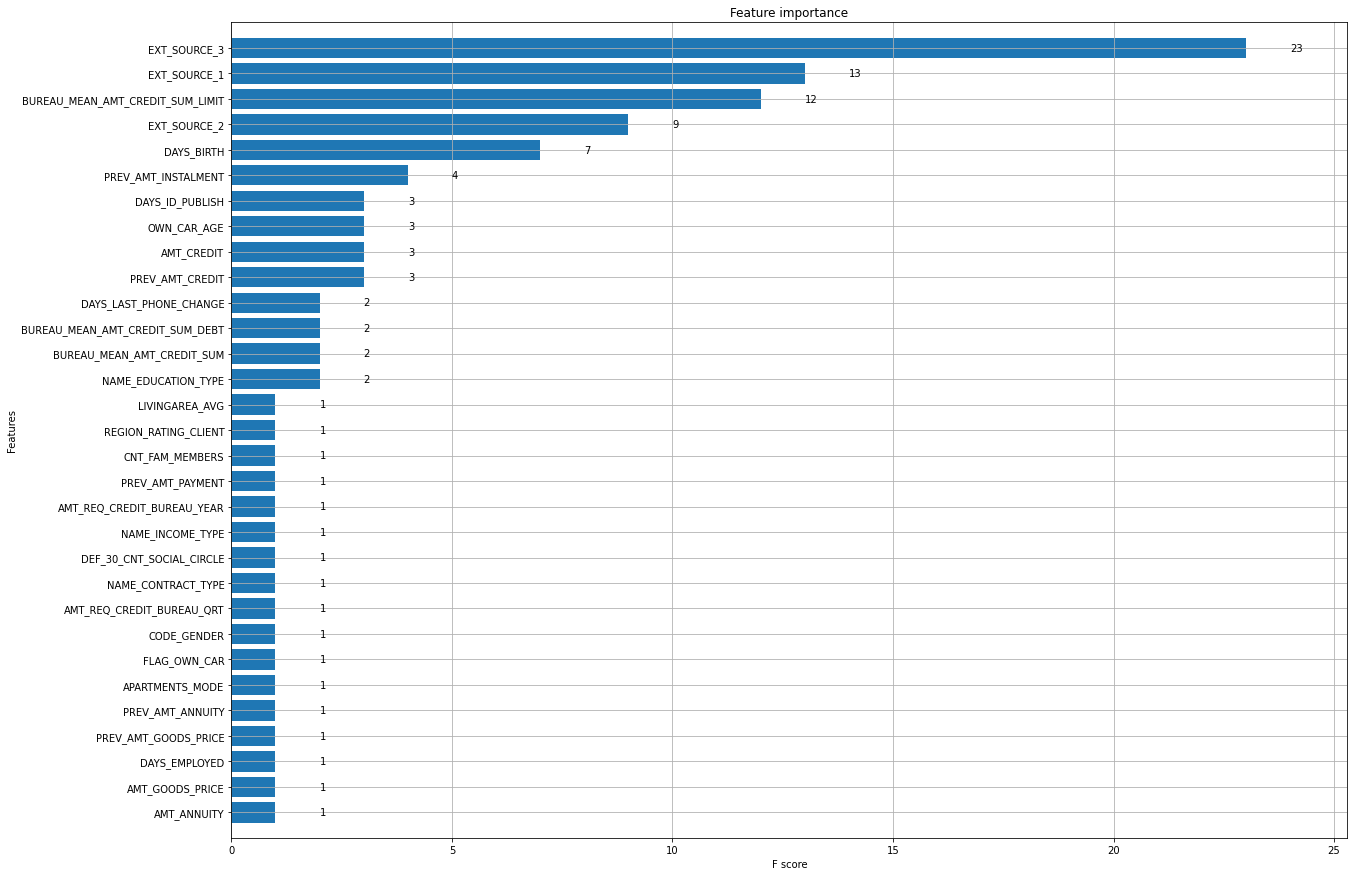

In [43]:
train_Y = train_df['TARGET']                   
train_X = train_df.drop(["TARGET","SK_ID_CURR"], axis=1)

scaler = StandardScaler()  

train_X_scale = scaler.fit(train_X).transform(train_X)

xgr = XGBRegressor(n_estimators=15, learning_rate=1.0, objective='binary:logistic', 
                    booster='gbtree',n_jobs= -1, 
                    min_child_weight=30, subsample=0.5, 
                    colsample_bytree=0.9, reg_alpha=0.01, reg_lambda=0.05,
                    random_state=101)

xgr.fit(train_X, train_Y)

plt.figure(figsize=(20,15))
xgb.plot_importance(xgr, max_num_features=50, height=0.8, ax=plt.gca());

affichage des valeurs

In [44]:
importances_df = \
pd.DataFrame({'feature':train_X.columns,
              'importance':np.round(xgr.feature_importances_,3)})
importances_df = importances_df.sort_values('importance', ascending=False)
importances_df[:30]

,feature,importance
23,EXT_SOURCE_3,0.145
22,EXT_SOURCE_2,0.093
2,AMT_GOODS_PRICE,0.073
40,NAME_EDUCATION_TYPE,0.073
59,BUREAU_MEAN_AMT_CREDIT_SUM_LIMIT,0.070
0,AMT_ANNUITY,0.063
14,DAYS_EMPLOYED,0.054
13,DAYS_BIRTH,0.043
21,EXT_SOURCE_1,0.042
1,AMT_CREDIT,0.036


conservation seulement des colonnes dont l'importance est supérieure à 0.019

In [45]:
feat_df = pd.DataFrame(importances_df[importances_df['importance']>=0.019])
feat_col = list(feat_df['feature'])
print ("Nombre de features sélectionnés :  ", len(feat_col))

del train_X, train_Y, importances_df, train_X_scale
gc.collect()

Nombre de features sélectionnés :   16


7595

# V - LogisticRegression

In [ ]:
X = train_df[feat_col].copy()
y = train_df.TARGET.copy()

## a) weighted

### i) exploration de C

In [ ]:
params =  {'C' : [10**i for i in range(-12,5,2)],
           'class_weight' : ['balanced']}

results = classify_with_gridsearchcv(X, y, clf=LogisticRegression(), 
                                     params_grid=params, scoring=roc_auc_score, 
                                     predictions='proba', rand=36)

In [ ]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'C': 10000, 'class_weight': 'balanced', 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.6048348335182985


### ii) tracé de score = f(C)

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfa06e14d0>,
       dtype=object))

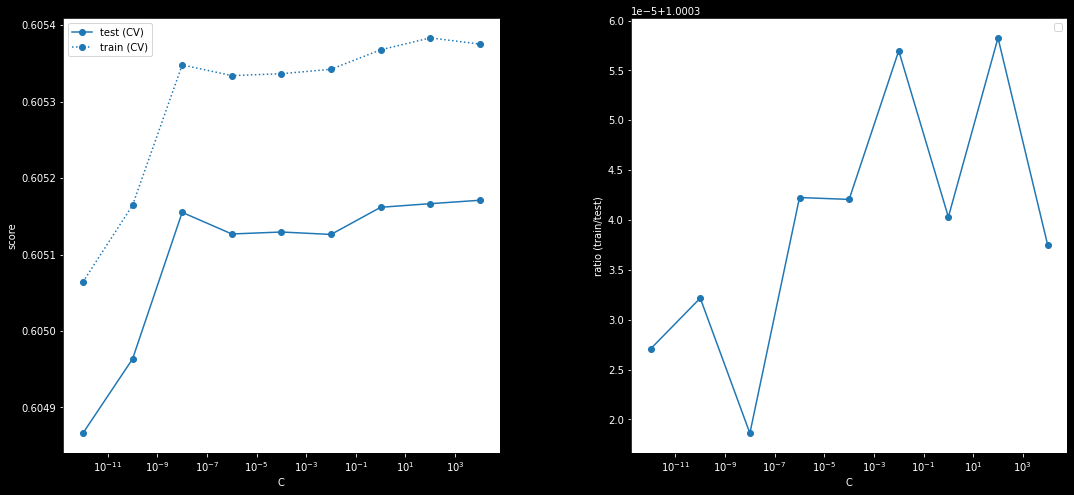

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results}, 
                               paramaters=params['C'], 
                               name_param='C',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### iii) matrices de confusion

sans sample_weight

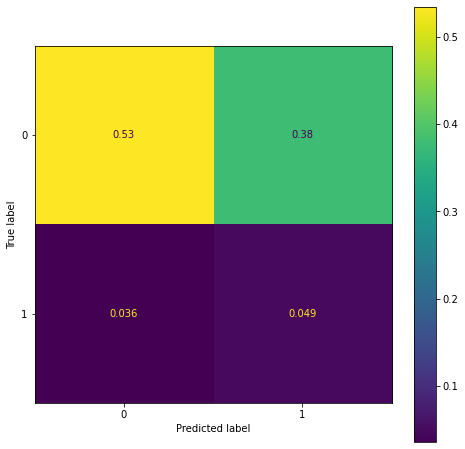

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

scorer = make_scorer(roc_auc_score, needs_threshold=True)

clf = LogisticRegression()
params_grid = {'C' : [10000],
               'class_weight' : ['balanced']}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

avec sample_weight

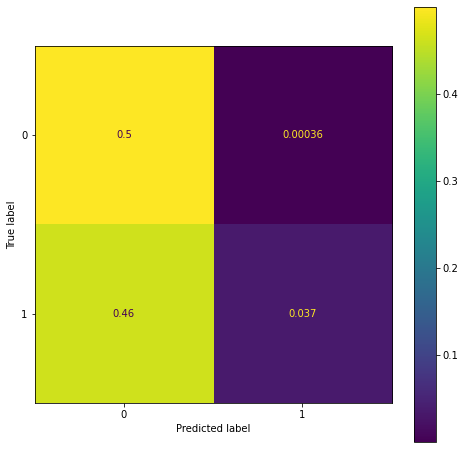

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

### iv) matrices de confusion (C = 10^-8, pour éviter le sur-apprentissage)

sans sample_weight

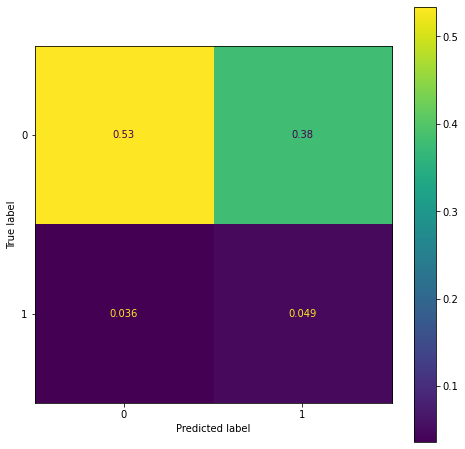

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

scorer = make_scorer(roc_auc_score, needs_threshold=True)

clf = LogisticRegression()
params_grid = {'C' : [10**(-8)],
               'class_weight' : ['balanced']}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

avec sample_weight

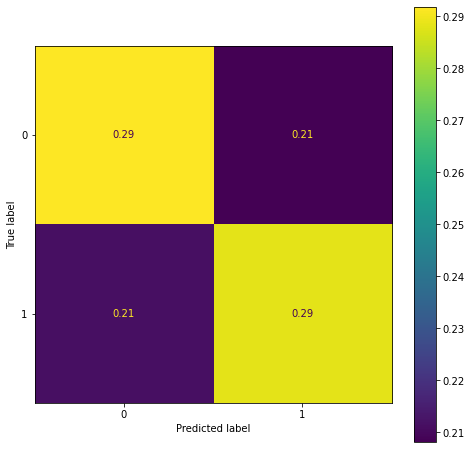

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

## b) undersampling

### i) prétraitement des données

séparation train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

application de l'undersampling aux données

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

X_under, y_under = undersample.fit_resample(X_train, y_train)

In [ ]:
percent_0_all = 100 * y_under[y_under==0].size / y_under.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_under".format(percent_0_all))

Il y a 50.000% de 0 dans l'ensemble de y_under


### ii) exploration de C

In [ ]:
params =  {'C' : [10**i for i in range(-12,5,2)]}

results = classify_with_gridsearchcv(X_under, y_under, clf=LogisticRegression(), 
                                     params_grid=params, scoring=roc_auc_score, 
                                     predictions='proba', rand=36)

In [ ]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'C': 1, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.6056497434995213


### iii) tracé de score = f(C)

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf97a9e150>,
       dtype=object))

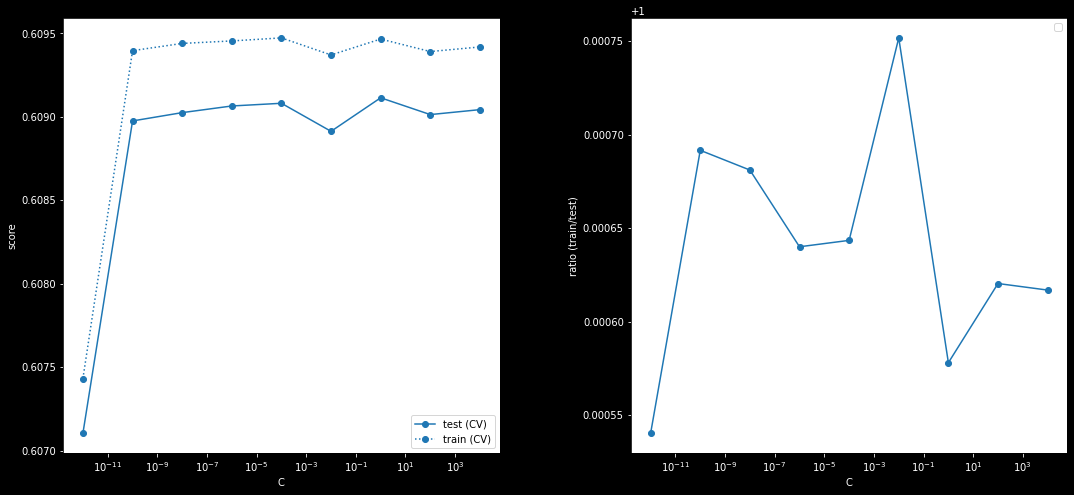

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results}, 
                               paramaters=params['C'], 
                               name_param='C',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### iv) matrices de confusion

sans sample_weight

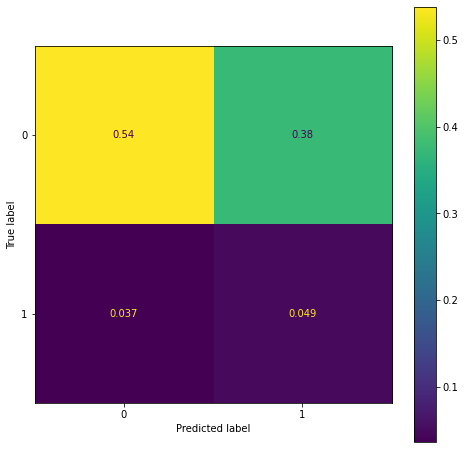

In [ ]:
scorer = make_scorer(roc_auc_score, needs_threshold=True)

clf = LogisticRegression()
params_grid = {'C' : [1]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_under, y_under)

X_test = np.array(X_test)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

avec sample_weight

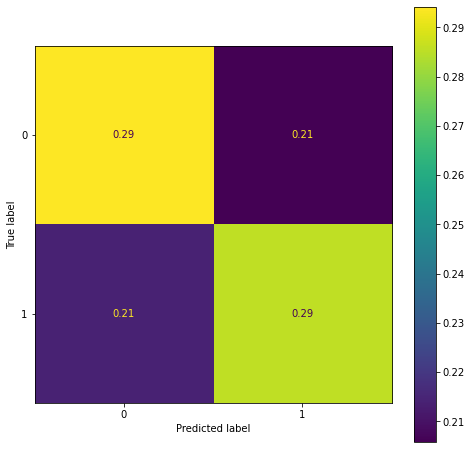

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

## c) oversampling

### i) prétraitement des données

séparation train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

application de l'oversampling aux données

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
percent_0_all = 100 * y_over[y_over==0].size / y_over.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over".format(percent_0_all))

Il y a 50.000% de 0 dans l'ensemble de y_over


### ii) exploration de C

In [ ]:
params =  {'C' : [10**i for i in range(-12,5,2)]}

results = classify_with_gridsearchcv(X_over, y_over, clf=LogisticRegression(), 
                                     params_grid=params, scoring=roc_auc_score, 
                                     predictions='proba', rand=36)

In [ ]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'C': 0.0001, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.6066076361708154


### iii) tracé de score = f(C)

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf97709310>,
       dtype=object))

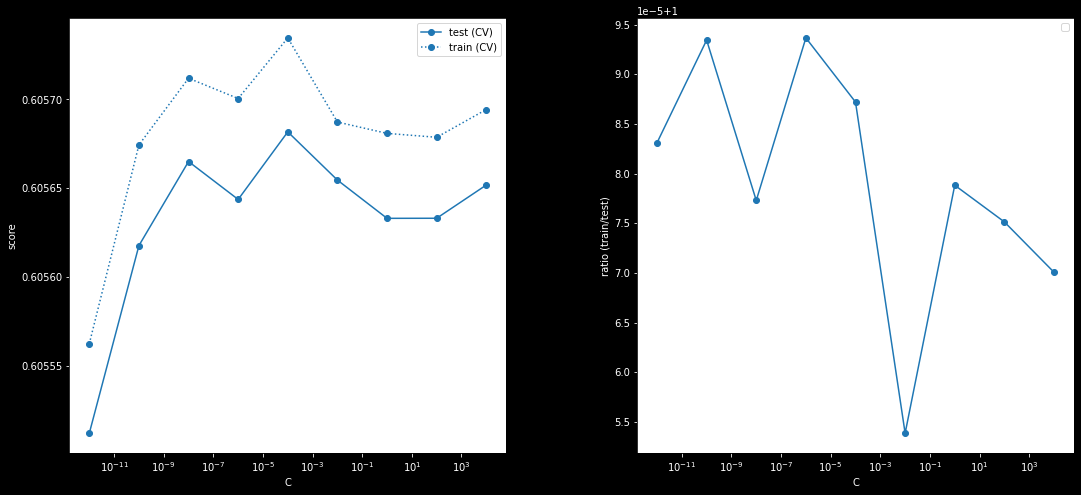

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results}, 
                               paramaters=params['C'], 
                               name_param='C',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### iv) matrices de confusion

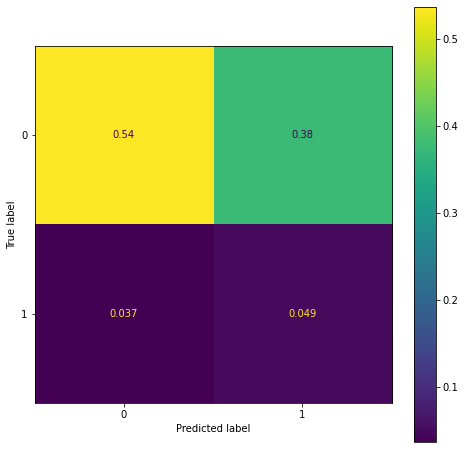

In [ ]:
scorer = make_scorer(roc_auc_score, needs_threshold=True)

clf = LogisticRegression()
params_grid = {'C' : [1]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_over, y_over)

X_test = np.array(X_test)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

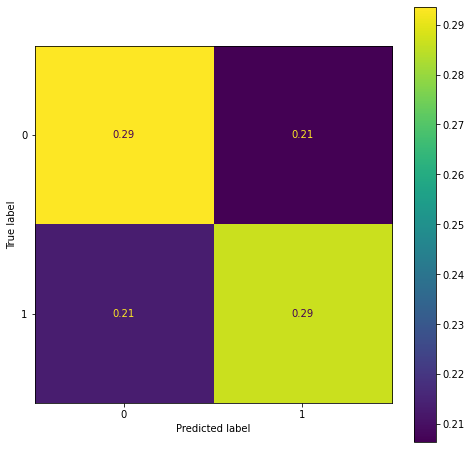

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

# VI - RandomForestClassifier 

In [ ]:
X = train_df[feat_col].copy()
y = train_df.TARGET.copy()

## a) weighted (échantillon réduit)

### i) prétraitement des données

création d'un sous-échantillon pour raison de temps de calcul

In [ ]:
X_short, X_test, y_short, y_test = train_test_split(
    X, y, test_size=0.8, random_state=36)

In [ ]:
percent_0_all = 100 * y_short[y_short==0].size / y_short.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_short".format(percent_0_all))

percent_0_all = 100 * y[y==0].size / y.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y".format(percent_0_all))

Il y a 91.299% de 0 dans l'ensemble de y_short
Il y a 91.388% de 0 dans l'ensemble de y


### ii) exploration de n_estimators et max_depth 

In [ ]:
params = {'n_estimators' : [32,64,128,256],
          'max_depth' : [7,15,30],
          'class_weight' : ['balanced'],
          'random_state' : [41]}

results = classify_with_gridsearchcv(X_short, y_short, clf=RandomForestClassifier(), 
                                     params_grid=params, scoring=roc_auc_score, 
                                     predictions='proba', rand=36)

In [ ]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 256, 'random_state': 41, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.8493305860226549


### iii) tracé des résultats

tracé de score = f(n_estimators) (max_depth=30)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['max_depth']==30]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf9748a550>,
       dtype=object))

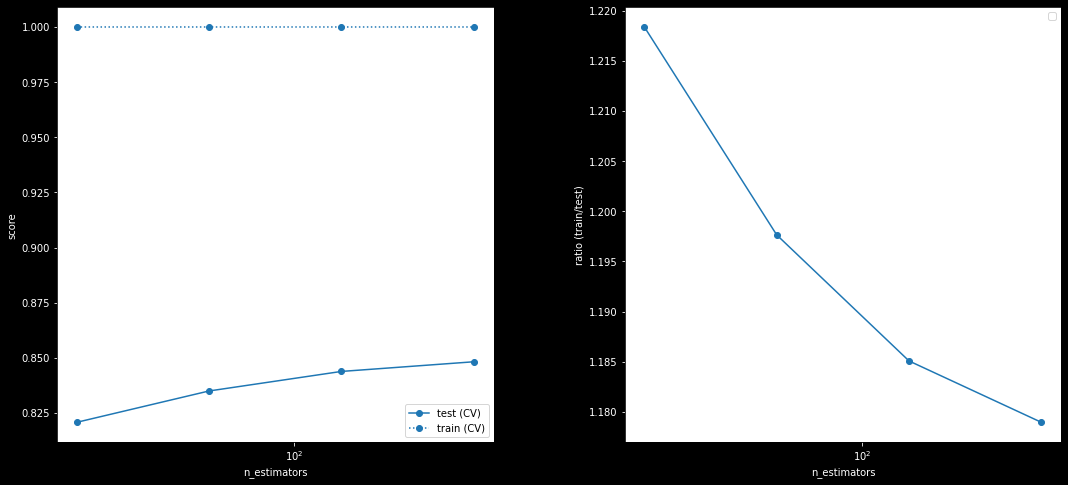

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['n_estimators'], 
                               name_param='n_estimators',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

tracé de score = f(max_depth) (n_estimators=256)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['n_estimators']==256]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf97dd9910>,
       dtype=object))

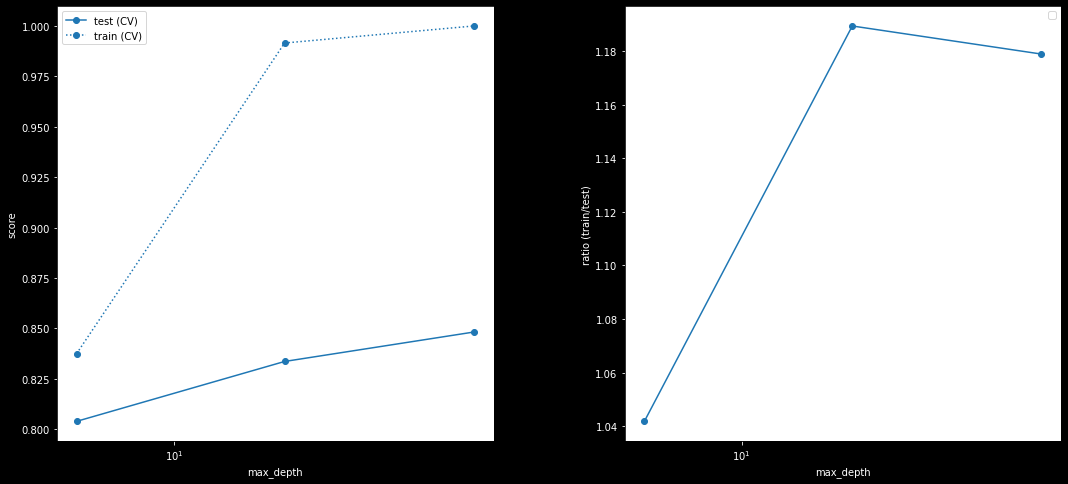

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['max_depth'], 
                               name_param='max_depth',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### iv) matrices de confusion

sans sample_weight

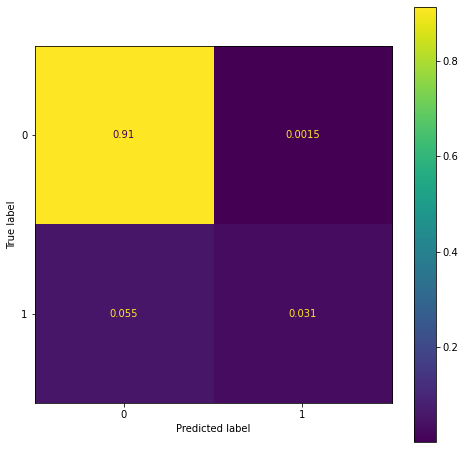

In [ ]:
scorer = make_scorer(roc_auc_score, needs_threshold=True)

clf = RandomForestClassifier()
params_grid = {'n_estimators' : [256],
               'max_depth' : [30],
               'class_weight' : ['balanced'],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_short, y_short)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

avec sample_weight

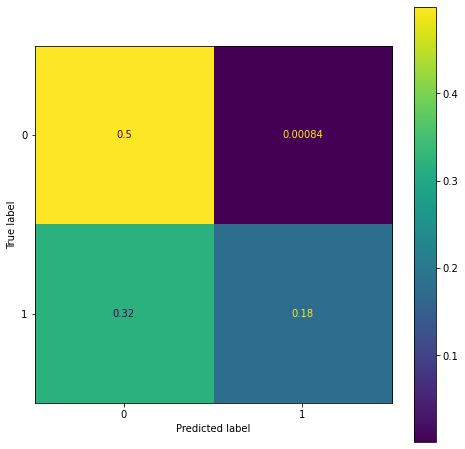

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

### v) matrices de confusion (max_depth=7, pour éviter sur-apprentissage)

sans sample_weight

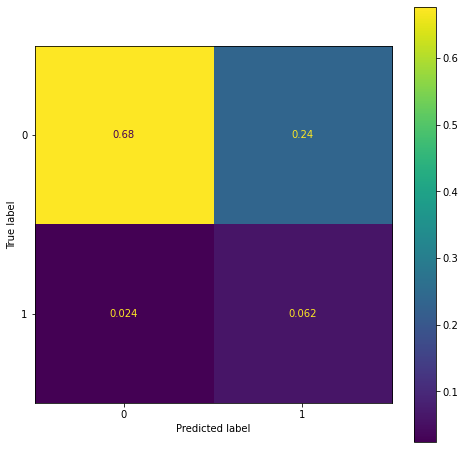

In [ ]:
scorer = make_scorer(roc_auc_score, needs_threshold=True)

clf = RandomForestClassifier()
params_grid = {'n_estimators' : [256],
               'max_depth' : [7],
               'class_weight' : ['balanced'],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_short, y_short)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

avec sample_weight

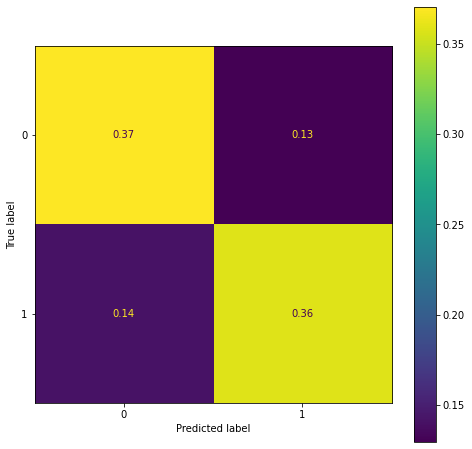

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

## b) undersampling

### i) prétraitement des données

séparation train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

application de l'undersampling aux données

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

X_under, y_under = undersample.fit_resample(X_train, y_train)

In [ ]:
percent_0_all = 100 * y_under[y_under==0].size / y_under.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_under".format(percent_0_all))

Il y a 50.000% de 0 dans l'ensemble de y_under


### ii) exploration de n_estimators et max_depth 

In [ ]:
params = {'n_estimators' : [32,64,128,256],
          'max_depth' : [7,15,30],
          'random_state' : [41]}

results = classify_with_gridsearchcv(X_under, y_under, clf=RandomForestClassifier(), 
                                     params_grid=params, scoring=roc_auc_score, 
                                     predictions='proba', rand=36)

In [ ]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 256, 'random_state': 41, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.9047774515878206


### iii) tracé des résultats

tracé de score = f(n_estimators) (max_depth=30)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['max_depth']==30]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf96eef090>,
       dtype=object))

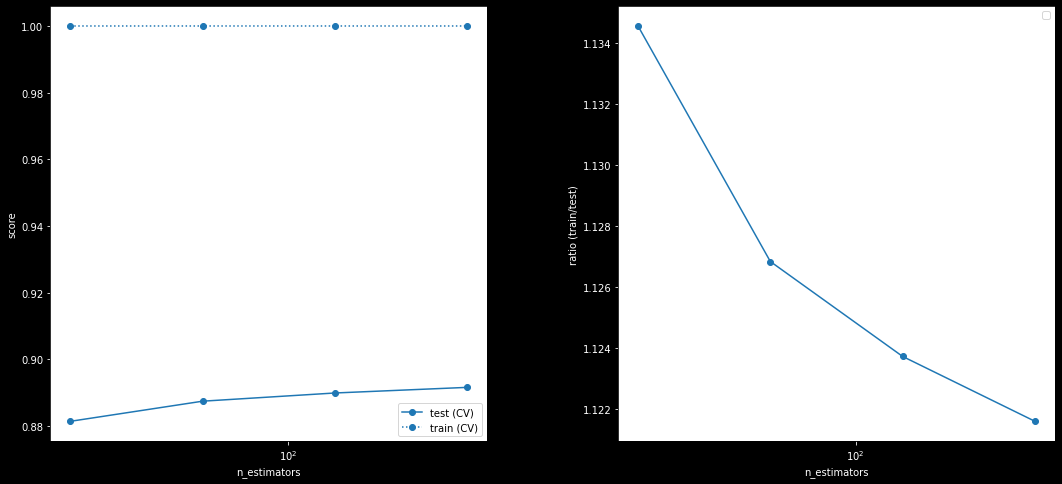

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['n_estimators'], 
                               name_param='n_estimators',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

tracé de score = f(max_depth) (n_estimators=256)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['n_estimators']==256]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf96a00790>,
       dtype=object))

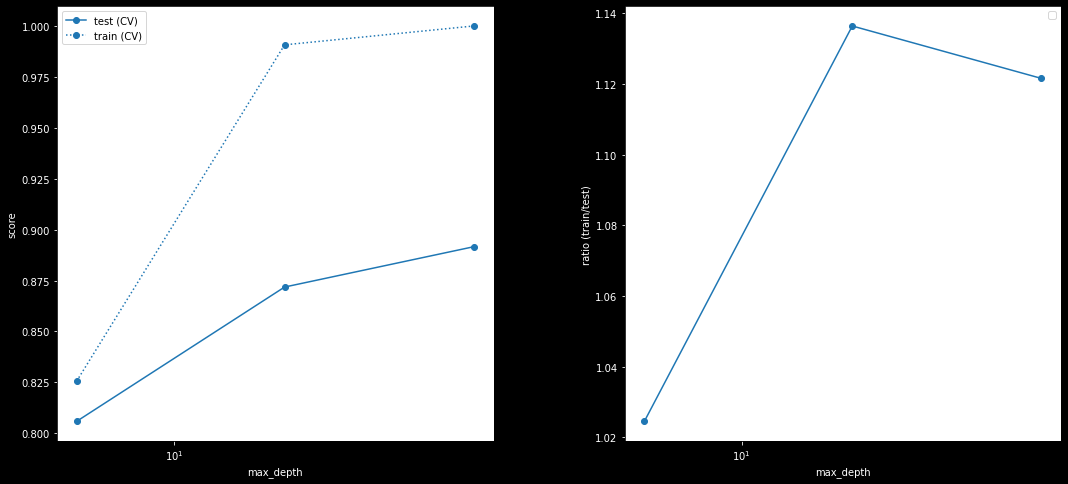

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['max_depth'], 
                               name_param='max_depth',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### iv) matrices de confusion

sans sample_weight

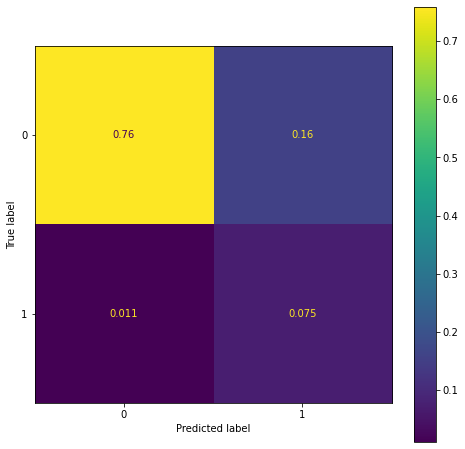

In [ ]:
scorer = make_scorer(roc_auc_score, needs_threshold=True)

clf = RandomForestClassifier()
params_grid = {'n_estimators' : [256],
               'max_depth' : [30],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_under, y_under)

X_test = np.array(X_test)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

avec sample_weight

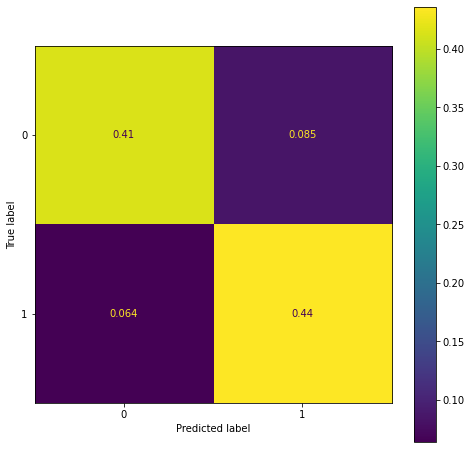

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

## c) oversampling (échantillon réduit)

### i) prétraitement des données

séparation train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

application de l'oversampling aux données puis créaton d'un sous-échantillon pour raison de temps de calcul

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
X_over_short, X_over_test, y_over_short, y_over_test = train_test_split(
    X_over, y_over, test_size=0.8, random_state=36)

In [ ]:
percent_0_all = 100 * y_over_short[y_over_short==0].size / y_over_short.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over_short".format(percent_0_all))

percent_0_all = 100 * y_over[y_over==0].size / y_over.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over".format(percent_0_all))

Il y a 49.892% de 0 dans l'ensemble de y_over_short
Il y a 50.000% de 0 dans l'ensemble de y_over


### ii) exploration de n_estimators et max_depth

In [ ]:
params = {'n_estimators' : [32,64,128,256],
          'max_depth' : [7,15,30],
          'random_state' : [41]}

results = classify_with_gridsearchcv(X_over_short, y_over_short, clf=RandomForestClassifier(), 
                                     params_grid=params, scoring=roc_auc_score, 
                                     predictions='proba', rand=36)

In [ ]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'max_depth': 30, 'n_estimators': 256, 'random_state': 41, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.9804786384852687


### iii) tracé des résultats

tracé de score = f(n_estimators) (max_depth=30)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['max_depth']==30]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf965b90d0>,
       dtype=object))

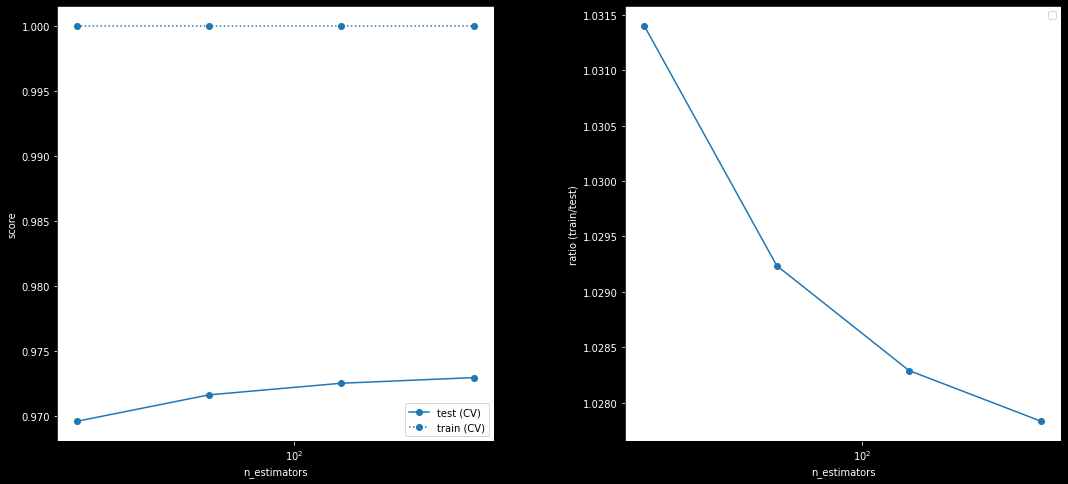

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['n_estimators'], 
                               name_param='n_estimators',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

tracé de score = f(max_depth) (n_estimators=256)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['n_estimators']==256]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf9709f790>,
       dtype=object))

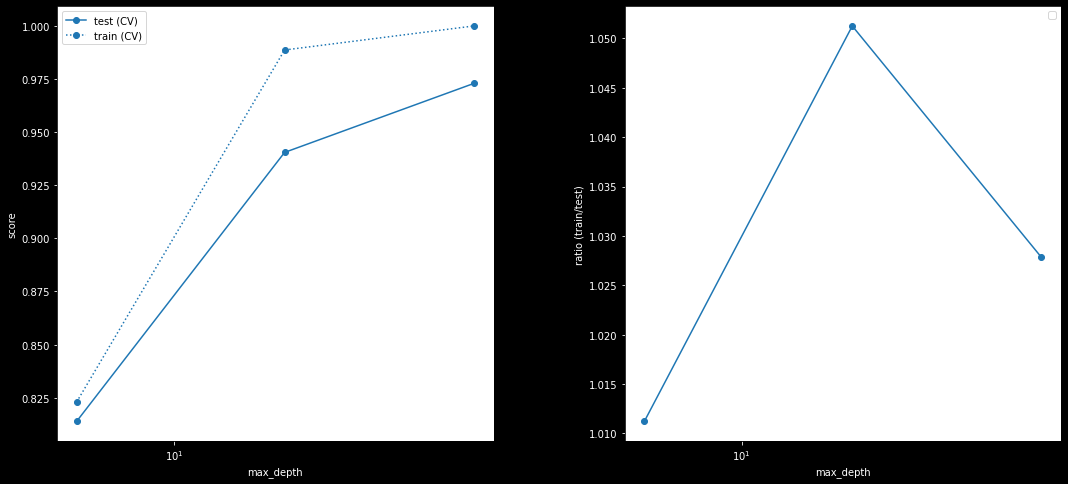

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['max_depth'], 
                               name_param='max_depth',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### iv) matrices de confusion 

sans sample_weight

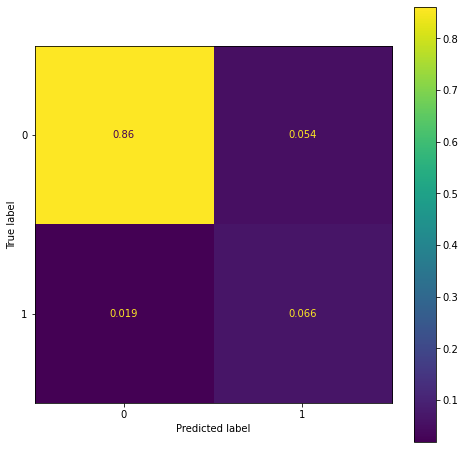

In [ ]:
scorer = make_scorer(roc_auc_score, needs_threshold=True)

clf = RandomForestClassifier()
params_grid = {'n_estimators' : [256],
               'max_depth' : [30],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_over_short, y_over_short)

X_test = np.array(X_test)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

avec sample_weight

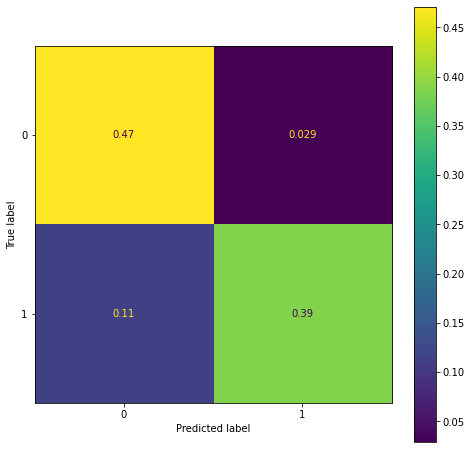

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

# VII - XGBClassifier

In [ ]:
X = train_df[feat_col].copy()
y = train_df.TARGET.copy()

## a) weighted (échantillon réduit)

### i) prétraitement de données

création d'un sous-échantillon pour raison de temps de calcul

In [ ]:
X_short, X_test, y_short, y_test = train_test_split(
    X, y, test_size=0.8, random_state=36)

In [ ]:
percent_0_all = 100 * y_short[y_short==0].size / y_short.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_short".format(percent_0_all))

percent_0_all = 100 * y[y==0].size / y.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y".format(percent_0_all))

Il y a 91.299% de 0 dans l'ensemble de y_short
Il y a 91.388% de 0 dans l'ensemble de y


calcul du paramètre scale_pos_weight

In [ ]:
ratio_0_1 = y_short[y_short==0].size / y_short[y_short==1].size

### ii) exploration de n_estimators et max_depth 

In [ ]:
params = {'n_estimators' : [32,64,128,256],
          'max_depth' : [7,15,30],
          'scale_pos_weight' : [ratio_0_1],
          'use_label_encoder' : [False],
          'random_state' : [41]}

results = classify_with_gridsearchcv(X_short, y_short, clf=XGBClassifier(), 
                                     params_grid=params, scoring=roc_auc_score, 
                                     predictions='proba', rand=36)

In [ ]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'max_depth': 30, 'n_estimators': 128, 'random_state': 41, 'scale_pos_weight': 10.493033226152198, 'use_label_encoder': False, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.845515589622166


### iii) tracé de résultats

tracé de score = f(n_estimators) (max_depth=30)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['max_depth']==30]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c63fbea90>,
       dtype=object))

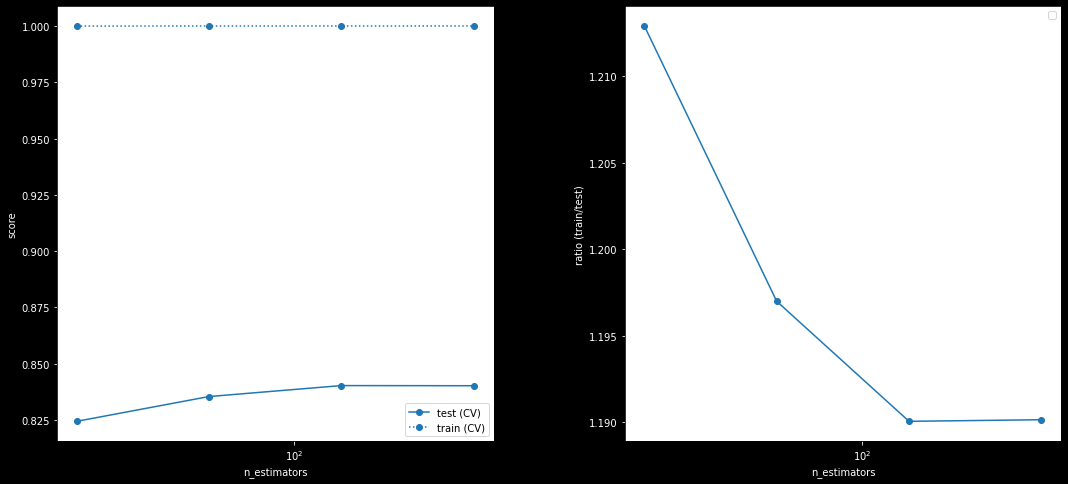

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['n_estimators'], 
                               name_param='n_estimators',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

tracé de score = f(max_depth) (n_estimators=128)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['n_estimators']==128]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c63cf14d0>,
       dtype=object))

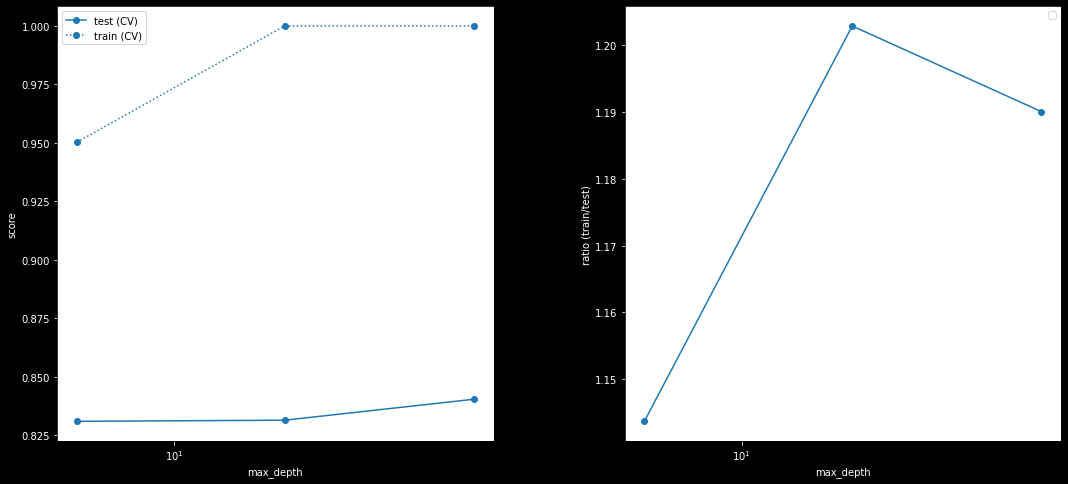

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['max_depth'], 
                               name_param='max_depth',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### iv) matrices de confusion

sans sample_weight

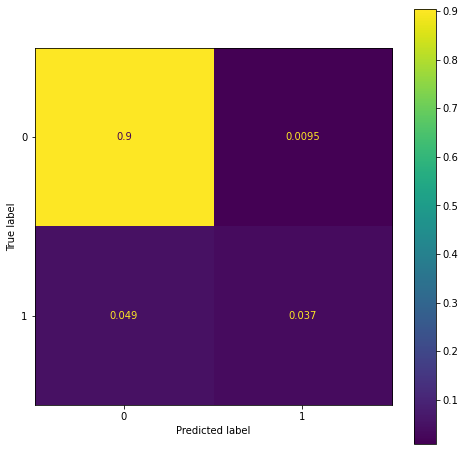

In [ ]:
scorer = make_scorer(roc_auc_score, needs_threshold=True)

clf = XGBClassifier()
params_grid = {'n_estimators' : [128],
               'max_depth' : [30],
               'scale_pos_weight' : [ratio_0_1],
               'use_label_encoder' : [False],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_short, y_short)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

avec sample_weight

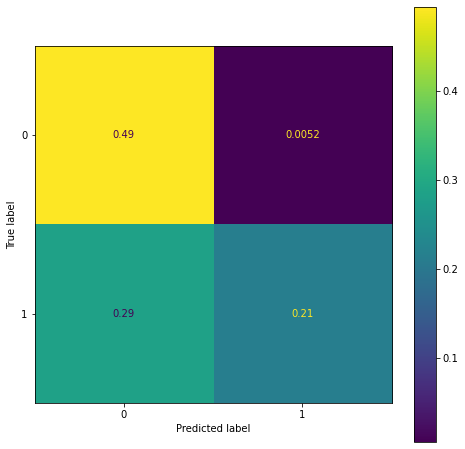

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

### v) matrices de confusion (max_depth=7, pour éviter sur-apprentissage)

sans sample_weight

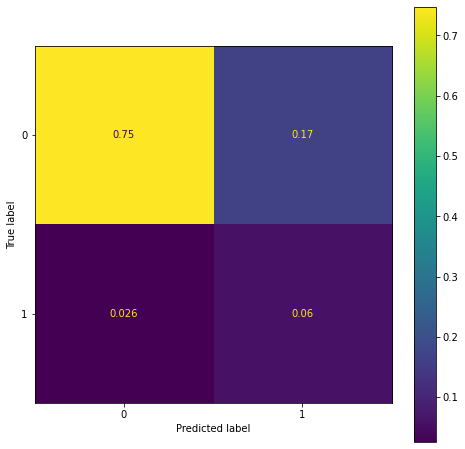

In [ ]:
scorer = make_scorer(roc_auc_score, needs_threshold=True)

clf = XGBClassifier()
params_grid = {'n_estimators' : [128],
               'max_depth' : [7],
               'scale_pos_weight' : [ratio_0_1],
               'use_label_encoder' : [False],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_short, y_short)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

avec sample_weight

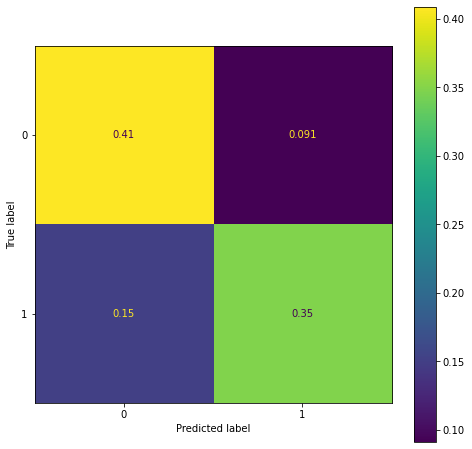

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

## b) undersampling

### i) prétraitement des données

séparation train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

application de l'undersampling aux données

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

X_under, y_under = undersample.fit_resample(X_train, y_train)

In [ ]:
percent_0_all = 100 * y_under[y_under==0].size / y_under.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_under".format(percent_0_all))

Il y a 50.000% de 0 dans l'ensemble de y_under


### ii) exploration de n_estimators et max_depth 

In [ ]:
params = {'n_estimators' : [32,64,128,256],
          'max_depth' : [7,15,30],
          'use_label_encoder' : [False],
          'random_state' : [41]}

results = classify_with_gridsearchcv(X_under, y_under, clf=XGBClassifier(), 
                                     params_grid=params, scoring=roc_auc_score, 
                                     predictions='proba', rand=36)

In [ ]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'max_depth': 30, 'n_estimators': 256, 'random_state': 41, 'use_label_encoder': False, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.9018865825679918


### iii) tracé de résultats

tracé de score = f(n_estimators) (max_depth=30)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['max_depth']==30]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfa2df0610>,
       dtype=object))

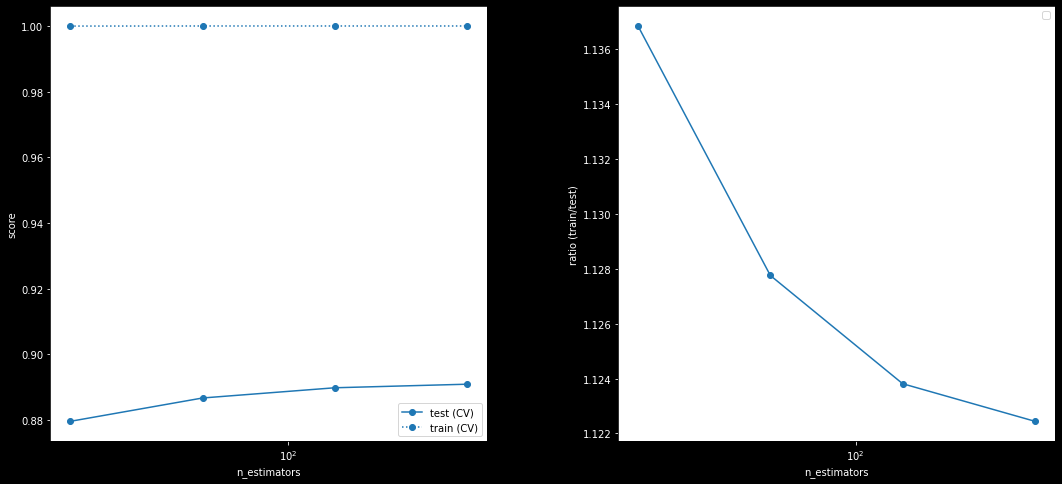

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['n_estimators'], 
                               name_param='n_estimators',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

tracé de score = f(max_depth) (n_estimators=256)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['n_estimators']==256]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfa29690d0>,
       dtype=object))

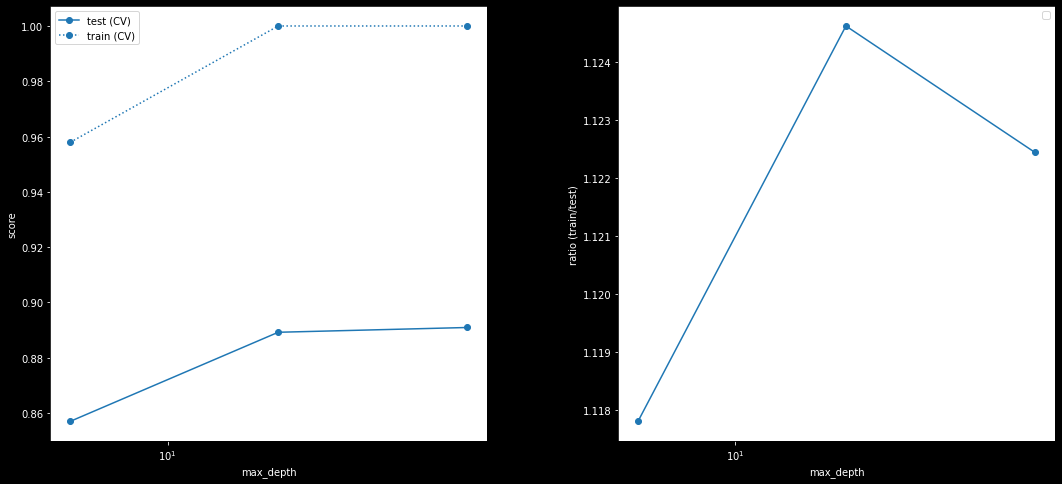

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['max_depth'], 
                               name_param='max_depth',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### iv) matrices de confusion

sans sample_weight

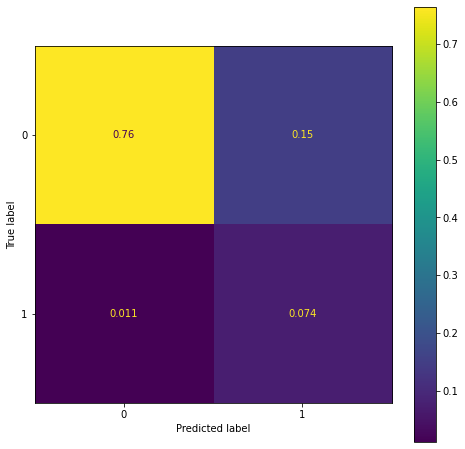

In [ ]:
scorer = make_scorer(roc_auc_score, needs_threshold=True)

clf = XGBClassifier()
params_grid = {'n_estimators' : [256],
               'max_depth' : [30],
               'use_label_encoder' : [False],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_under, y_under)

X_test = np.array(X_test)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

avec sample_weight

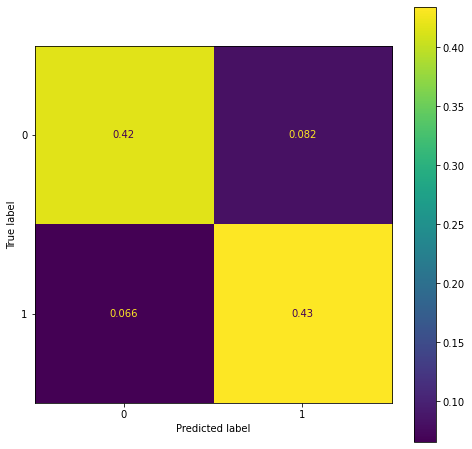

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

## c) oversampling (échantillon réduit)

### i) prétraitement de données

séparation train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

application de l'oversampling aux données puis créaton d'un sous-échantillon pour raison de temps de calcul

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
X_over_short, X_over_test, y_over_short, y_over_test = train_test_split(
    X_over, y_over, test_size=0.8, random_state=36)

In [ ]:
percent_0_all = 100 * y_over_short[y_over_short==0].size / y_over_short.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over_short".format(percent_0_all))

percent_0_all = 100 * y_over[y_over==0].size / y_over.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over".format(percent_0_all))

Il y a 49.892% de 0 dans l'ensemble de y_over_short
Il y a 50.000% de 0 dans l'ensemble de y_over


### ii) exploration de n_estimators et max_depth

In [ ]:
params = {'n_estimators' : [32,64,128,256],
          'max_depth' : [7,15,30],
          'use_label_encoder' : [False],
          'random_state' : [41]}

results = classify_with_gridsearchcv(X_over_short, y_over_short, clf=XGBClassifier(), 
                                     params_grid=params, scoring=roc_auc_score, 
                                     predictions='proba', rand=36)

In [ ]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'max_depth': 30, 'n_estimators': 256, 'random_state': 41, 'use_label_encoder': False, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.9812068076757099


### iii) tracé de résultats

tracé de score = f(n_estimators) (max_depth=30)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['max_depth']==30]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c6359d850>,
       dtype=object))

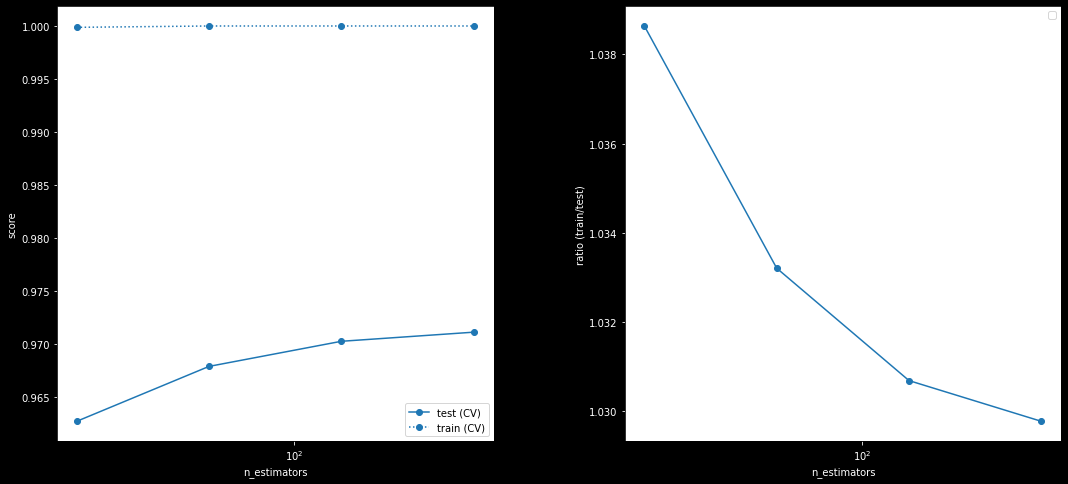

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['n_estimators'], 
                               name_param='n_estimators',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

tracé de score = f(max_depth) (n_estimators=256)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['n_estimators']==256]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c633d40d0>,
       dtype=object))

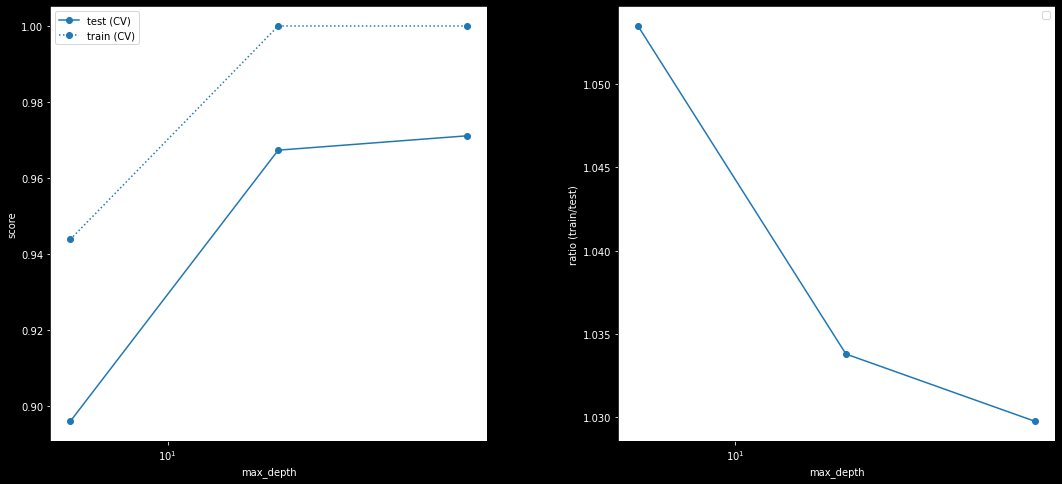

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['max_depth'], 
                               name_param='max_depth',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### iv) matrices de confusion (échantillon réduit)

sans sample_weight

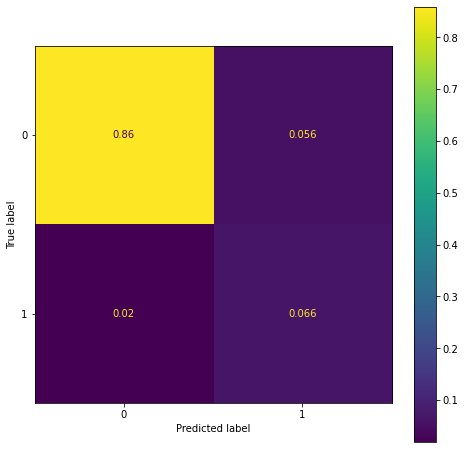

In [ ]:
scorer = make_scorer(roc_auc_score, needs_threshold=True)

clf = XGBClassifier()
params_grid = {'n_estimators' : [256],
               'max_depth' : [30],
               'use_label_encoder' : [False],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_over_short, y_over_short)

X_test = np.array(X_test)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

avec sample_weight

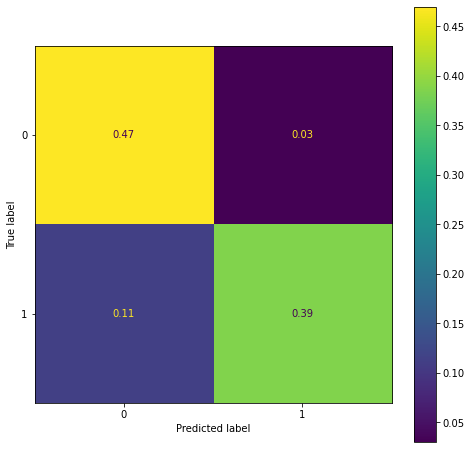

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

# VIII - Scores personnalisés (XGBClassifier + oversampling)

plus f1-score

## a) f1-score (échantillon réduit)

In [ ]:
X = train_df[feat_col].copy()
y = train_df.TARGET.copy()

### i) prétraitement des données

séparation train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

application de l'oversampling aux données puis créaton d'un sous-échantillon pour raison de temps de calcul

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
X_over_short, X_over_test, y_over_short, y_over_test = train_test_split(
    X_over, y_over, test_size=0.8, random_state=36)

In [ ]:
percent_0_all = 100 * y_over_short[y_over_short==0].size / y_over_short.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over_short".format(percent_0_all))

percent_0_all = 100 * y_over[y_over==0].size / y_over.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over".format(percent_0_all))

Il y a 49.892% de 0 dans l'ensemble de y_over_short
Il y a 50.000% de 0 dans l'ensemble de y_over


### ii) exploration de n_estimators et max_depth

In [ ]:
params = {'n_estimators' : [32,64,128,256],
          'max_depth' : [7,15,30],
          'use_label_encoder' : [False],
          'random_state' : [41]}

results = classify_with_gridsearchcv(X_over_short, y_over_short, clf=XGBClassifier(), 
                                     params_grid=params, scoring=f1_score, 
                                     predictions='labels', rand=36)

In [ ]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'max_depth': 30, 'n_estimators': 256, 'random_state': 41, 'use_label_encoder': False, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.9300159216748651


### iii) tracé de résultats

tracé de score = f(n_estimators) (max_depth=30)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['max_depth']==30]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7632b55390>,
       dtype=object))

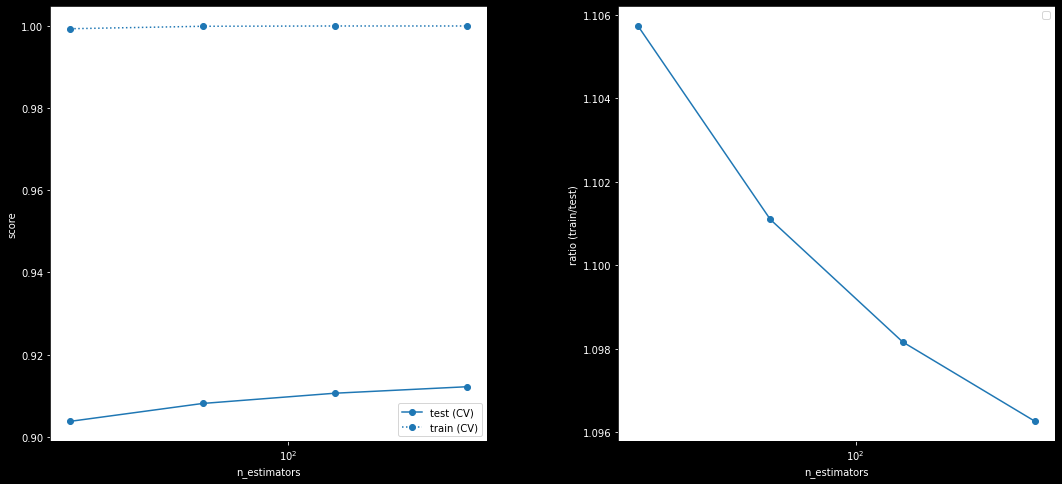

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['n_estimators'], 
                               name_param='n_estimators',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

tracé de score = f(max_depth) (n_estimators=256)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['n_estimators']==256]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f76325b4410>,
       dtype=object))

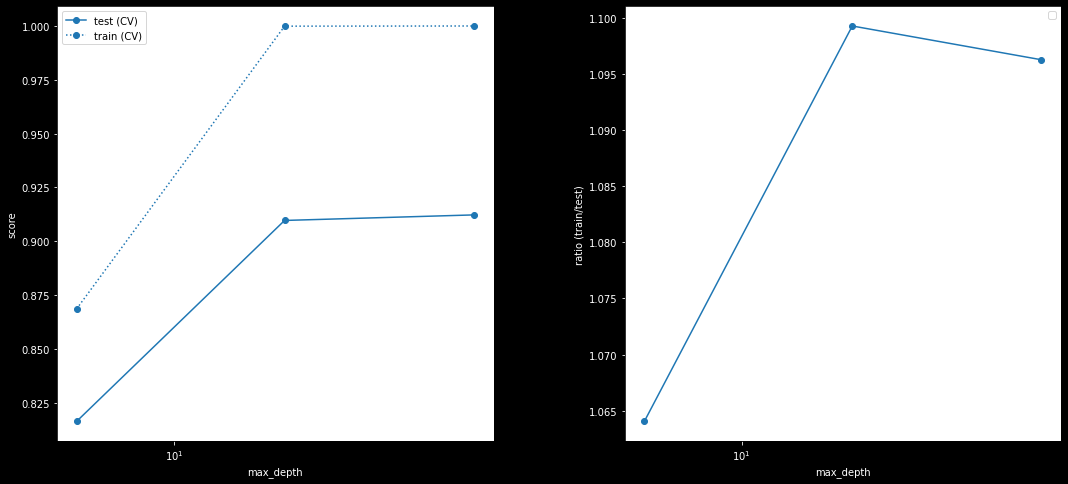

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['max_depth'], 
                               name_param='max_depth',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### iv) matrices de confusion (échantillon réduit)

sans sample_weight

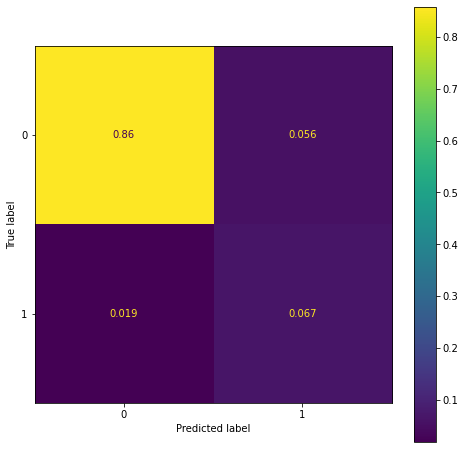

In [ ]:
scorer = make_scorer(f1_score)

clf = XGBClassifier()
params_grid = {'n_estimators' : [256],
               'max_depth' : [30],
               'use_label_encoder' : [False],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_over_short, y_over_short)

X_test = np.array(X_test)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

avec sample_weight

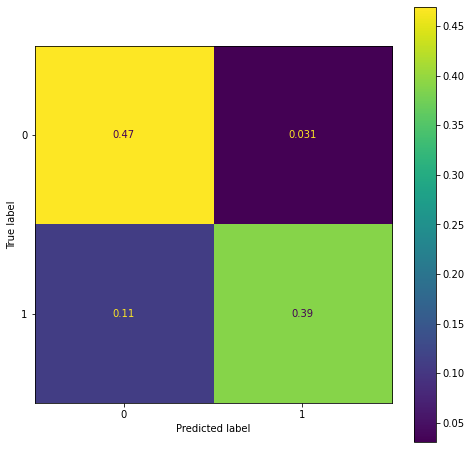

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

## b) scoring personnalisé (1) (échantillon réduit)

In [ ]:
X = train_df[feat_col].copy()
y = train_df.TARGET.copy()

### i) définition de la fonction qui va calculer le score

Voici les points attribués à chaque élément de la prédiction :
- true positive : prêt remboursé => 1
- true negative : pas de prêt et n'aurait pas pu être remboursé => 1
- false positive : prêt non remboursé => -1
- false negative : pas de prêt alors qu'il aurait été remboursé => -1

Ensuite le plus petit score possible (tous les éléments ont le plus petit coefficient) est retiré à la somme des points. Enfin, le résultat est divisé par la diiférence entre le plus grand score possible (tous les éléments ont le plus grand coefficient) et le plus petit.

In [ ]:
def my_score(y_true, y_pred):

    coeff_TP = 1
    coeff_TN = 1
    coeff_FP = -1
    coeff_FN = -1

    # vrai positifs : prédits 0 et vraiment 0 (prêt / peut rembourser)
    condition1 = (y_true==y_pred)
    condition2 = (y_true==0)
    y = np.where(condition1 * condition2)
    n_true_positive = np.size(y)

    # vrai négatifs : prédits 1 et vraiment 1 (non prêt / peut pas rembourser)
    condition2 =  (y_true==1)
    y = np.where(condition1 * condition2)
    n_true_negative = np.size(y)

    # faux positifs : prédits 0 alors que 1 (prêt / peut pas rembourser)
    condition1 = (y_true!=y_pred)
    condition2 = (y_true==1)
    y = np.where(condition1 * condition2)
    n_false_positive = np.size(y)

    # faux négatifs : prédits 1 alors que 0 (non prêt / peut rembourser)
    condition2 =  (y_true==0)
    y = np.where(condition1 * condition2)
    n_false_negative = np.size(y)

    score = (coeff_TP * n_true_positive + coeff_TN * n_true_negative) +\
            (coeff_FP * n_false_positive + coeff_FN * n_false_negative)

    score_min = min(coeff_FP,coeff_FN) * np.size(y_true)
    score_max = max(coeff_TP,coeff_TN) * np.size(y_true)

    score = (score - score_min) / (score_max - score_min) 
    
    return score  

### ii) prétraitement des données

séparation train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

application de l'oversampling aux données puis créaton d'un sous-échantillon pour raison de temps de calcul

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
X_over_short, X_over_test, y_over_short, y_over_test = train_test_split(
    X_over, y_over, test_size=0.8, random_state=36)

In [ ]:
percent_0_all = 100 * y_over_short[y_over_short==0].size / y_over_short.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over_short".format(percent_0_all))

percent_0_all = 100 * y_over[y_over==0].size / y_over.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over".format(percent_0_all))

Il y a 49.892% de 0 dans l'ensemble de y_over_short
Il y a 50.000% de 0 dans l'ensemble de y_over


### iii) exploration de n_estimators et max_depth

In [ ]:
params = {'n_estimators' : [32,64,128,256],
          'max_depth' : [7,15,30],
          'use_label_encoder' : [False],
          'random_state' : [41]}

results = classify_with_gridsearchcv(X_over_short, y_over_short, clf=XGBClassifier(), 
                                     params_grid=params, scoring=my_score, 
                                     predictions='labels', rand=36)

In [ ]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'max_depth': 30, 'n_estimators': 256, 'random_state': 41, 'use_label_encoder': False, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.9279204840943887


### iv) tracé de résultats

tracé de score = f(n_estimators) (max_depth=30)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['max_depth']==30]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f76343327d0>,
       dtype=object))

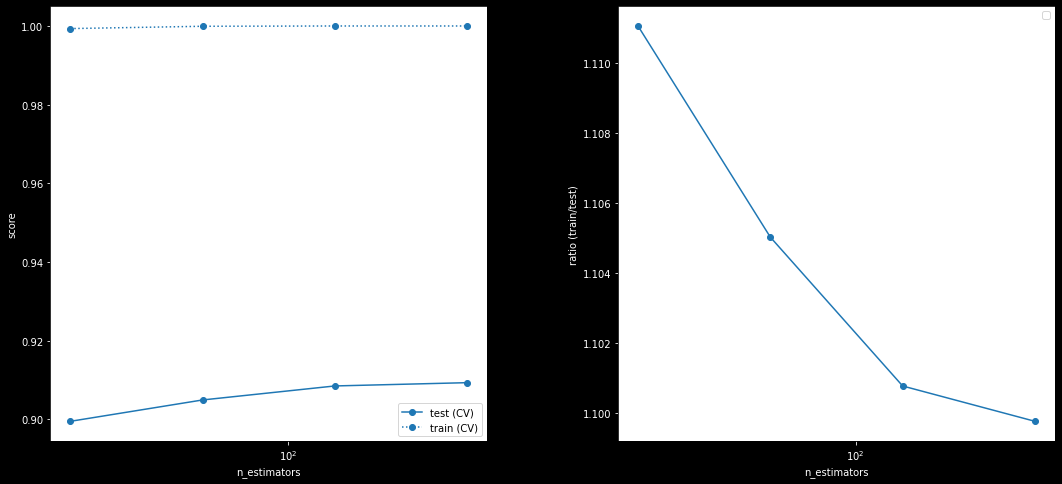

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['n_estimators'], 
                               name_param='n_estimators',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

tracé de score = f(max_depth) (n_estimators=256)

In [ ]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['n_estimators']==256]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f76309ce550>,
       dtype=object))

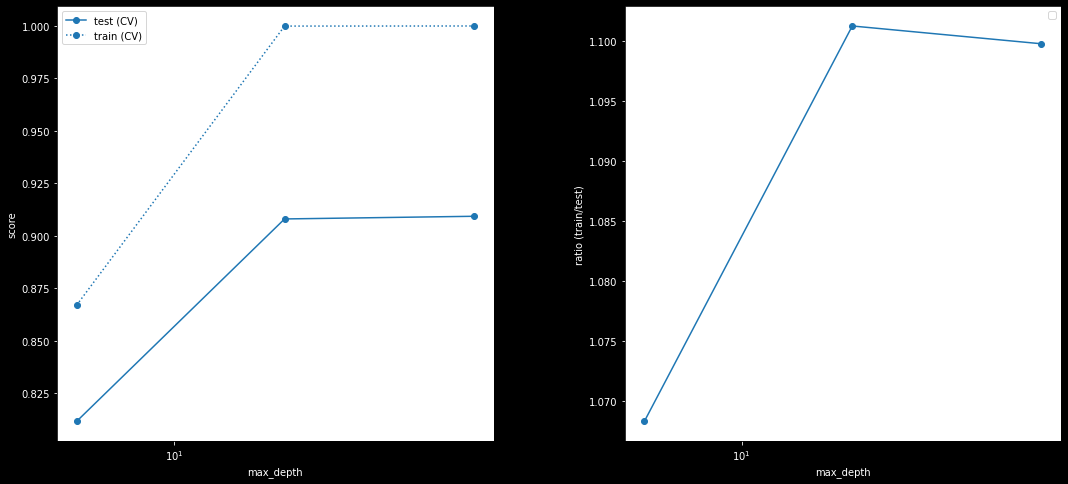

In [ ]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['max_depth'], 
                               name_param='max_depth',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### v) matrices de confusion (échantillon réduit)

sans sample_weight

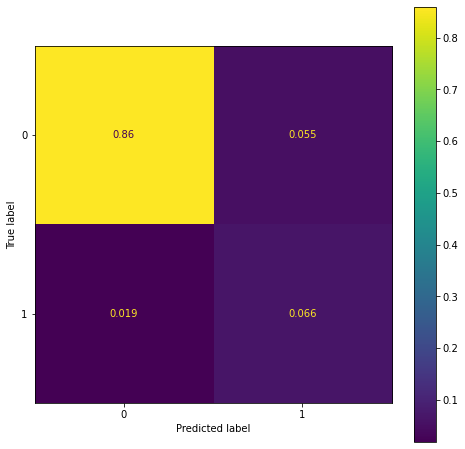

In [ ]:
scorer = make_scorer(my_score)

clf = XGBClassifier()
params_grid = {'n_estimators' : [256],
               'max_depth' : [30],
               'use_label_encoder' : [False],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_over_short, y_over_short)

X_test = np.array(X_test)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

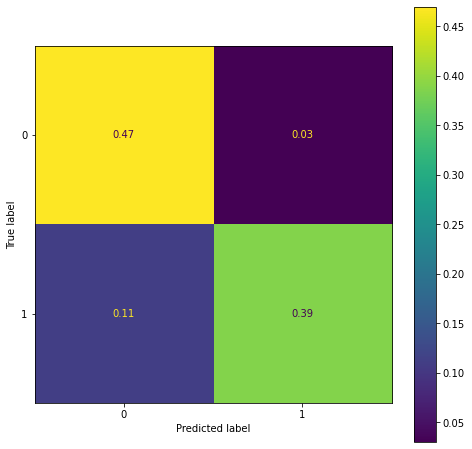

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

## c) scoring personnalisé (2) (échantillon réduit)

In [ ]:
X = train_df[feat_col].copy()
y = train_df.TARGET.copy()

### i) définition de la fonction qui va calculer le score

- true positive : prêt remboursé => 2
- true negative : pas de prêt et n'aurait pas pu être remboursé => 1
- false positive : prêt non remboursé => -2
- false negative : pas de prêt alors qu'il aurait été remboursé => -1

In [ ]:
def my_score(y_true, y_pred):

    coeff_TP = 2
    coeff_TN = 1
    coeff_FP = -2
    coeff_FN = -1

    # vrai positifs : prédits 0 et vraiment 0 (prêt / peut rembourser)
    condition1 = (y_true==y_pred)
    condition2 = (y_true==0)
    y = np.where(condition1 * condition2)
    n_true_positive = np.size(y)

    # vrai négatifs : prédits 1 et vraiment 1 (non prêt / peut pas rembourser)
    condition2 =  (y_true==1)
    y = np.where(condition1 * condition2)
    n_true_negative = np.size(y)

    # faux positifs : prédits 0 alors que 1 (prêt / peut pas rembourser)
    condition1 = (y_true!=y_pred)
    condition2 = (y_true==1)
    y = np.where(condition1 * condition2)
    n_false_positive = np.size(y)

    # faux négatifs : prédits 1 alors que 0 (non prêt / peut rembourser)
    condition2 =  (y_true==0)
    y = np.where(condition1 * condition2)
    n_false_negative = np.size(y)

    score = (coeff_TP * n_true_positive + coeff_TN * n_true_negative) +\
            (coeff_FP * n_false_positive + coeff_FN * n_false_negative)

    score_min = min(coeff_FP,coeff_FN) * np.size(y_true)
    score_max = max(coeff_TP,coeff_TN) * np.size(y_true)

    score = (score - score_min) / (score_max - score_min) 
    
    return score  

### ii) prétraitement des données

séparation train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

application de l'oversampling aux données puis créaton d'un sous-échantillon pour raison de temps de calcul

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
X_over_short, X_over_test, y_over_short, y_over_test = train_test_split(
    X_over, y_over, test_size=0.8, random_state=36)

In [ ]:
percent_0_all = 100 * y_over_short[y_over_short==0].size / y_over_short.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over_short".format(percent_0_all))

percent_0_all = 100 * y_over[y_over==0].size / y_over.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over".format(percent_0_all))

Il y a 49.892% de 0 dans l'ensemble de y_over_short
Il y a 50.000% de 0 dans l'ensemble de y_over


### iii) exploration de n_estimators et max_depth

In [56]:
params = {'n_estimators' : [32,64,128,256],
          'max_depth' : [7,15,30],
          'use_label_encoder' : [False],
          'random_state' : [41]}

results = classify_with_gridsearchcv(X_over_short, y_over_short, clf=XGBClassifier(), 
                                     params_grid=params, scoring=my_score, 
                                     predictions='labels', rand=36)

In [57]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'max_depth': 30, 'n_estimators': 256, 'random_state': 41, 'use_label_encoder': False, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.8208097402123988


### iv) tracé de résultats

tracé de score = f(n_estimators) (max_depth=30)

In [58]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['max_depth']==30]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2a4c70e50>,
       dtype=object))

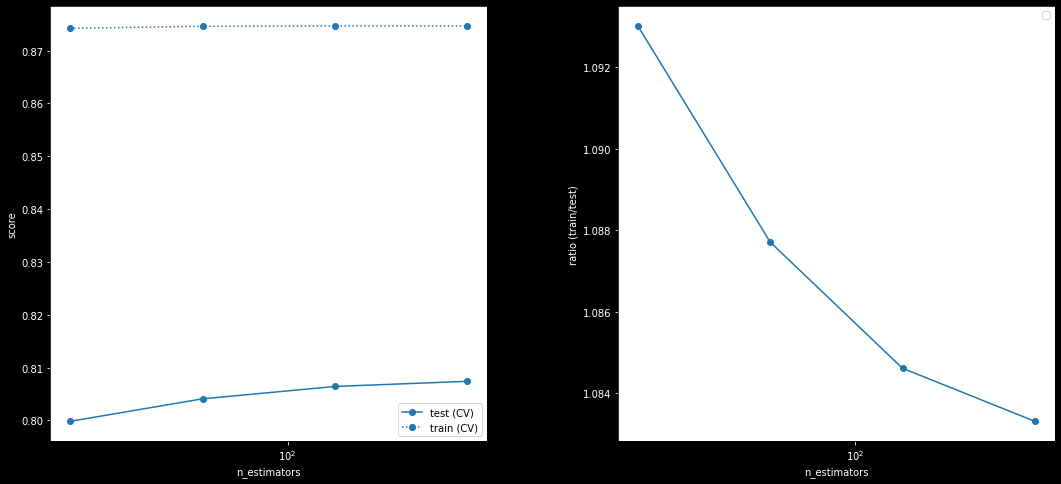

In [59]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['n_estimators'], 
                               name_param='n_estimators',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

tracé de score = f(max_depth) (n_estimators=256)

In [60]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['n_estimators']==256]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2a4c1a110>,
       dtype=object))

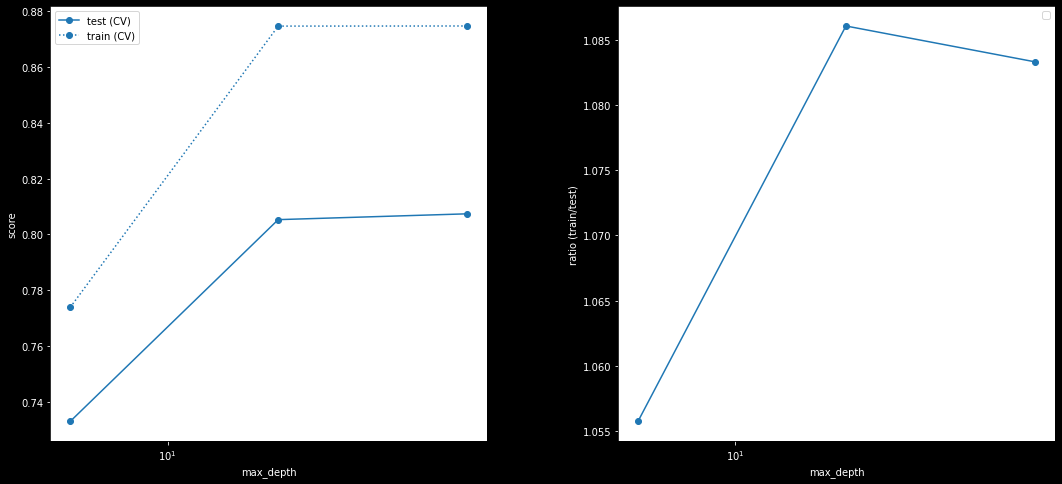

In [61]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['max_depth'], 
                               name_param='max_depth',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### v) matrices de confusion (échantillon réduit)

sans sample_weight

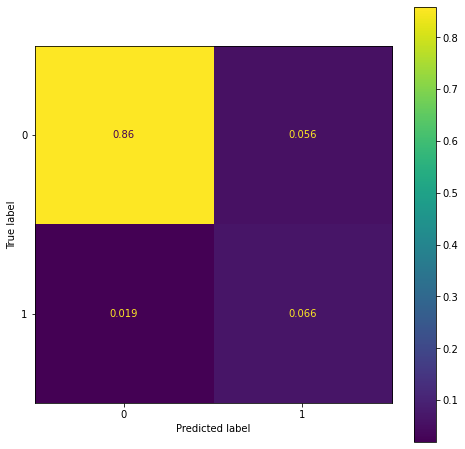

In [62]:
scorer = make_scorer(my_score)

clf = XGBClassifier()
params_grid = {'n_estimators' : [256],
               'max_depth' : [30],
               'use_label_encoder' : [False],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_over_short, y_over_short)

X_test = np.array(X_test)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

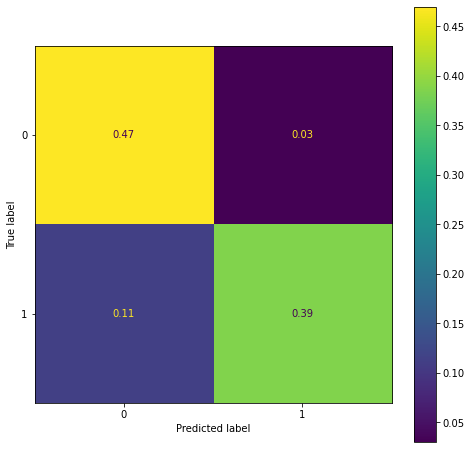

In [63]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

## d) scoring personnalisé (3) (échantillon réduit)

In [67]:
X = train_df[feat_col].copy()
y = train_df.TARGET.copy()

### i) définition de la fonction qui va calculer le score

- true positive : prêt remboursé => 1
- true negative : pas de prêt et n'aurait pas pu être remboursé => 2
- false positive : prêt non remboursé => -1
- false negative : pas de prêt alors qu'il aurait été remboursé => -2

In [ ]:
def my_score(y_true, y_pred):

    coeff_TP = 1
    coeff_TN = 2
    coeff_FP = -1
    coeff_FN = -2

    # vrai positifs : prédits 0 et vraiment 0 (prêt / peut rembourser)
    condition1 = (y_true==y_pred)
    condition2 = (y_true==0)
    y = np.where(condition1 * condition2)
    n_true_positive = np.size(y)

    # vrai négatifs : prédits 1 et vraiment 1 (non prêt / peut pas rembourser)
    condition2 =  (y_true==1)
    y = np.where(condition1 * condition2)
    n_true_negative = np.size(y)

    # faux positifs : prédits 0 alors que 1 (prêt / peut pas rembourser)
    condition1 = (y_true!=y_pred)
    condition2 = (y_true==1)
    y = np.where(condition1 * condition2)
    n_false_positive = np.size(y)

    # faux négatifs : prédits 1 alors que 0 (non prêt / peut rembourser)
    condition2 =  (y_true==0)
    y = np.where(condition1 * condition2)
    n_false_negative = np.size(y)

    score = (coeff_TP * n_true_positive + coeff_TN * n_true_negative) +\
            (coeff_FP * n_false_positive + coeff_FN * n_false_negative)

    score_min = min(coeff_FP,coeff_FN) * np.size(y_true)
    score_max = max(coeff_TP,coeff_TN) * np.size(y_true)

    score = (score - score_min) / (score_max - score_min) 
    
    return score  

### ii) prétraitement des données

séparation train-test

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

application de l'oversampling aux données puis créaton d'un sous-échantillon pour raison de temps de calcul

In [69]:
oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X_train, y_train)

In [70]:
X_over_short, X_over_test, y_over_short, y_over_test = train_test_split(
    X_over, y_over, test_size=0.8, random_state=36)

In [71]:
percent_0_all = 100 * y_over_short[y_over_short==0].size / y_over_short.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over_short".format(percent_0_all))

percent_0_all = 100 * y_over[y_over==0].size / y_over.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over".format(percent_0_all))

Il y a 49.892% de 0 dans l'ensemble de y_over_short
Il y a 50.000% de 0 dans l'ensemble de y_over


### iii) exploration de n_estimators et max_depth

In [72]:
params = {'n_estimators' : [32,64,128,256],
          'max_depth' : [7,15,30],
          'use_label_encoder' : [False],
          'random_state' : [41]}

results = classify_with_gridsearchcv(X_over_short, y_over_short, clf=XGBClassifier(), 
                                     params_grid=params, scoring=my_score, 
                                     predictions='labels', rand=36)

In [73]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'max_depth': 30, 'n_estimators': 256, 'random_state': 41, 'use_label_encoder': False, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.8196614741549005


### iv) tracé de résultats

tracé de score = f(n_estimators) (max_depth=30)

In [74]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['max_depth']==30]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2a4cbe910>,
       dtype=object))

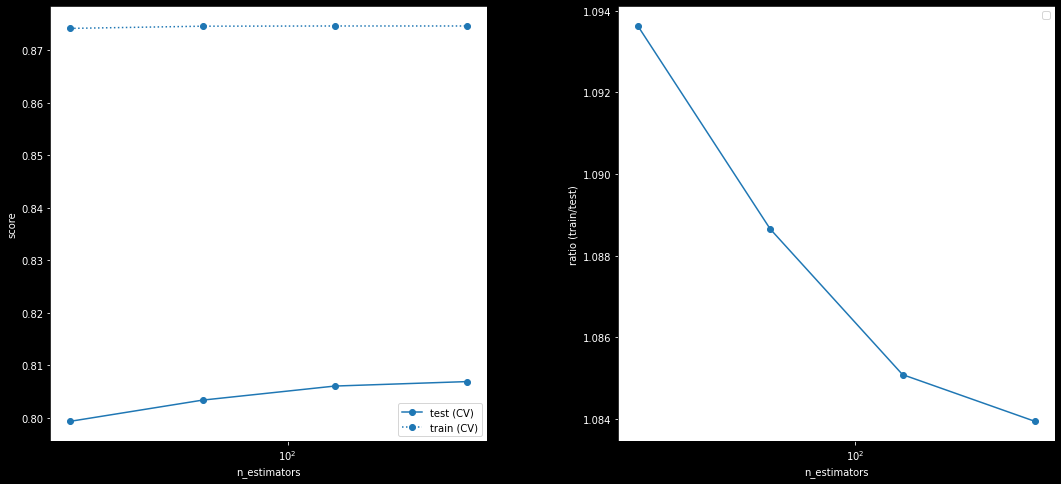

In [75]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['n_estimators'], 
                               name_param='n_estimators',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

tracé de score = f(max_depth) (n_estimators=256)

In [76]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['n_estimators']==256]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2a0aa8b50>,
       dtype=object))

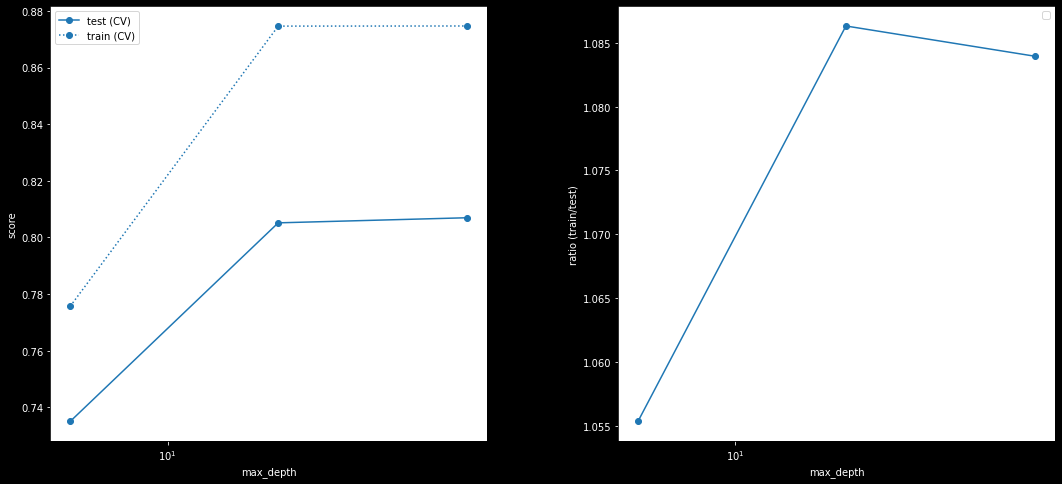

In [77]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['max_depth'], 
                               name_param='max_depth',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### v) matrices de confusion (échantillon réduit)

sans sample_weight

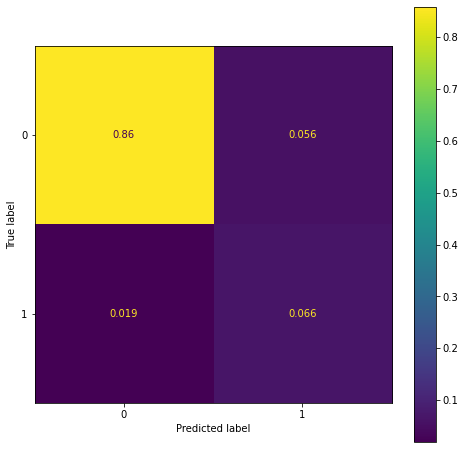

In [78]:
scorer = make_scorer(my_score)

clf = XGBClassifier()
params_grid = {'n_estimators' : [256],
               'max_depth' : [30],
               'use_label_encoder' : [False],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_over_short, y_over_short)

X_test = np.array(X_test)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

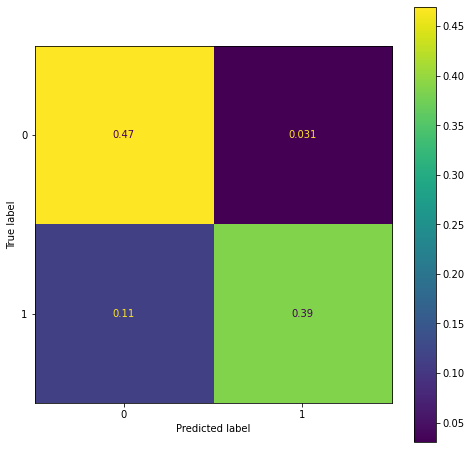

In [79]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

## e) scoring personnalisé (4) (échantillon réduit)

In [80]:
X = train_df[feat_col].copy()
y = train_df.TARGET.copy()

### i) définition de la fonction qui va calculer le score

- true positive : prêt remboursé => 1
- true negative : pas de prêt et n'aurait pas pu être remboursé => 0
- false positive : prêt non remboursé => -1
- false negative : pas de prêt alors qu'il aurait été remboursé => 0

In [81]:
def my_score(y_true, y_pred):

    coeff_TP = 1
    coeff_TN = 0
    coeff_FP = -1
    coeff_FN = 0

    # vrai positifs : prédits 0 et vraiment 0 (prêt / peut rembourser)
    condition1 = (y_true==y_pred)
    condition2 = (y_true==0)
    y = np.where(condition1 * condition2)
    n_true_positive = np.size(y)

    # vrai négatifs : prédits 1 et vraiment 1 (non prêt / peut pas rembourser)
    condition2 =  (y_true==1)
    y = np.where(condition1 * condition2)
    n_true_negative = np.size(y)

    # faux positifs : prédits 0 alors que 1 (prêt / peut pas rembourser)
    condition1 = (y_true!=y_pred)
    condition2 = (y_true==1)
    y = np.where(condition1 * condition2)
    n_false_positive = np.size(y)

    # faux négatifs : prédits 1 alors que 0 (non prêt / peut rembourser)
    condition2 =  (y_true==0)
    y = np.where(condition1 * condition2)
    n_false_negative = np.size(y)

    score = (coeff_TP * n_true_positive + coeff_TN * n_true_negative) +\
            (coeff_FP * n_false_positive + coeff_FN * n_false_negative)

    score_min = min(coeff_FP,coeff_FN) * np.size(y_true)
    score_max = max(coeff_TP,coeff_TN) * np.size(y_true)

    score = (score - score_min) / (score_max - score_min) 
    
    return score  

### ii) prétraitement des données

séparation train-test

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

application de l'oversampling aux données puis créaton d'un sous-échantillon pour raison de temps de calcul

In [83]:
oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X_train, y_train)

In [84]:
X_over_short, X_over_test, y_over_short, y_over_test = train_test_split(
    X_over, y_over, test_size=0.8, random_state=36)

In [85]:
percent_0_all = 100 * y_over_short[y_over_short==0].size / y_over_short.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over_short".format(percent_0_all))

percent_0_all = 100 * y_over[y_over==0].size / y_over.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over".format(percent_0_all))

Il y a 49.892% de 0 dans l'ensemble de y_over_short
Il y a 50.000% de 0 dans l'ensemble de y_over


### iii) exploration de n_estimators et max_depth

In [87]:
params = {'n_estimators' : [32,64,128,256],
          'max_depth' : [7,15,30],
          'use_label_encoder' : [False],
          'random_state' : [41]}

results = classify_with_gridsearchcv(X_over_short, y_over_short, clf=XGBClassifier(), 
                                     params_grid=params, scoring=my_score, 
                                     predictions='labels', rand=36)

In [88]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'max_depth': 30, 'n_estimators': 256, 'random_state': 41, 'use_label_encoder': False, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.7146832243796933


### iv) tracé de résultats

tracé de score = f(n_estimators) (max_depth=30)

In [93]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['max_depth']==30]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2a04847d0>,
       dtype=object))

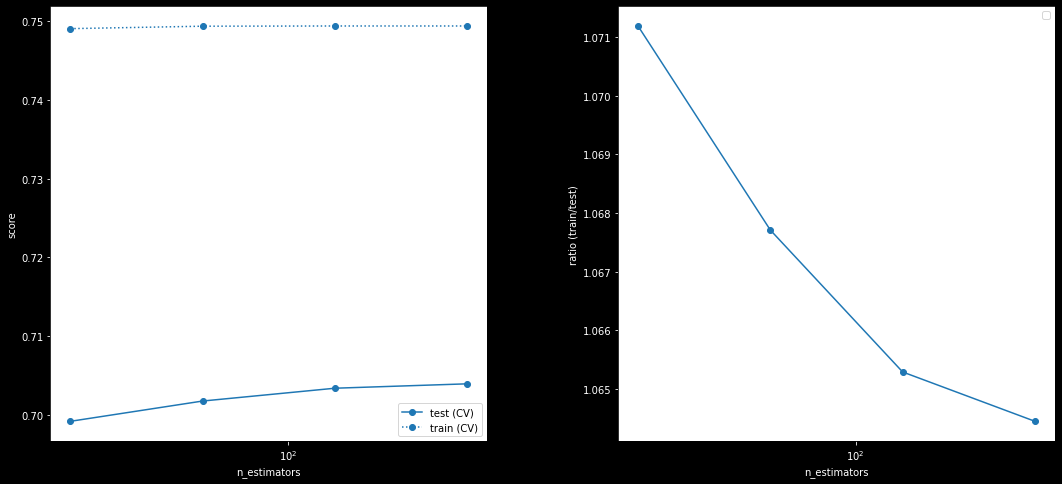

In [94]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['n_estimators'], 
                               name_param='n_estimators',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

tracé de score = f(max_depth) (n_estimators=256)

In [95]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['n_estimators']==256]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2a026a590>,
       dtype=object))

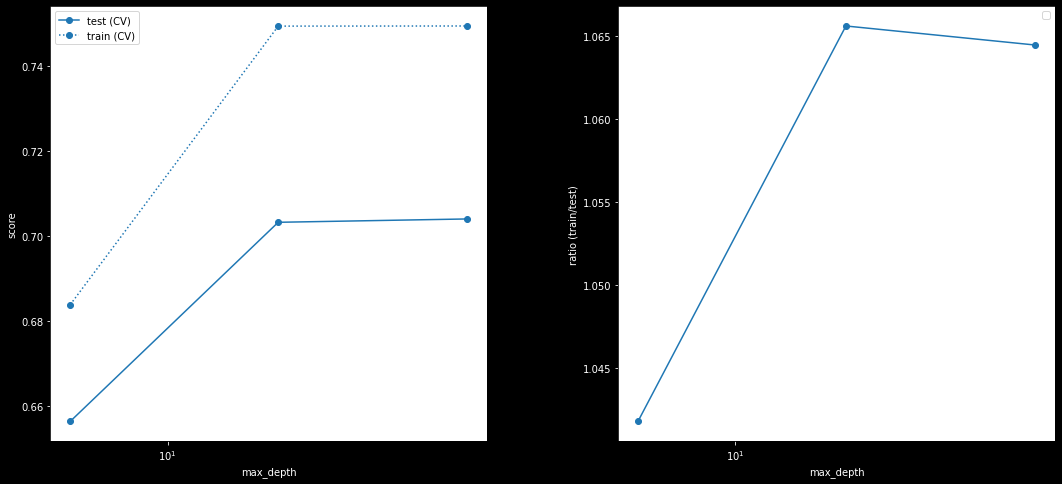

In [96]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['max_depth'], 
                               name_param='max_depth',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### v) matrices de confusion (échantillon réduit)

sans sample_weight

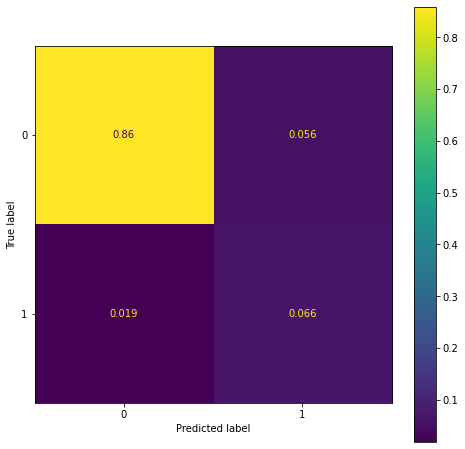

In [97]:
scorer = make_scorer(my_score)

clf = XGBClassifier()
params_grid = {'n_estimators' : [256],
               'max_depth' : [30],
               'use_label_encoder' : [False],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_over_short, y_over_short)

X_test = np.array(X_test)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

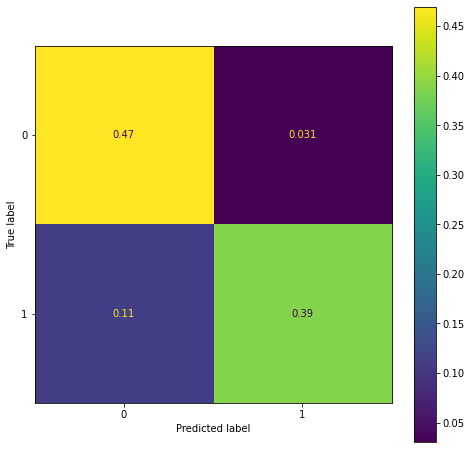

In [98]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

## f) scoring personnalisé (5) (échantillon réduit)

In [46]:
X = train_df[feat_col].copy()
y = train_df.TARGET.copy()

### i) définition de la fonction qui va calculer le score

- true positive : prêt remboursé => 0
- true negative : pas de prêt et n'aurait pas pu être remboursé => 1
- false positive : prêt non remboursé => 0
- false negative : pas de prêt alors qu'il aurait été remboursé => -1

In [47]:
def my_score(y_true, y_pred):

    coeff_TP = 0
    coeff_TN = 1
    coeff_FP = 0
    coeff_FN = -1

    # vrai positifs : prédits 0 et vraiment 0 (prêt / peut rembourser)
    condition1 = (y_true==y_pred)
    condition2 = (y_true==0)
    y = np.where(condition1 * condition2)
    n_true_positive = np.size(y)

    # vrai négatifs : prédits 1 et vraiment 1 (non prêt / peut pas rembourser)
    condition2 =  (y_true==1)
    y = np.where(condition1 * condition2)
    n_true_negative = np.size(y)

    # faux positifs : prédits 0 alors que 1 (prêt / peut pas rembourser)
    condition1 = (y_true!=y_pred)
    condition2 = (y_true==1)
    y = np.where(condition1 * condition2)
    n_false_positive = np.size(y)

    # faux négatifs : prédits 1 alors que 0 (non prêt / peut rembourser)
    condition2 =  (y_true==0)
    y = np.where(condition1 * condition2)
    n_false_negative = np.size(y)

    score = (coeff_TP * n_true_positive + coeff_TN * n_true_negative) +\
            (coeff_FP * n_false_positive + coeff_FN * n_false_negative)

    score_min = min(coeff_FP,coeff_FN) * np.size(y_true)
    score_max = max(coeff_TP,coeff_TN) * np.size(y_true)

    score = (score - score_min) / (score_max - score_min) 
    
    return score  

### ii) prétraitement des données

séparation train-test

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=36)

application de l'oversampling aux données puis créaton d'un sous-échantillon pour raison de temps de calcul

In [49]:
oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X_train, y_train)

In [50]:
X_over_short, X_over_test, y_over_short, y_over_test = train_test_split(
    X_over, y_over, test_size=0.8, random_state=36)

In [51]:
percent_0_all = 100 * y_over_short[y_over_short==0].size / y_over_short.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over_short".format(percent_0_all))

percent_0_all = 100 * y_over[y_over==0].size / y_over.size
print("Il y a {:.3f}% de 0 dans l'ensemble de y_over".format(percent_0_all))

Il y a 49.892% de 0 dans l'ensemble de y_over_short
Il y a 50.000% de 0 dans l'ensemble de y_over


### iii) exploration de n_estimators et max_depth

In [52]:
params = {'n_estimators' : [32,64,128,256],
          'max_depth' : [7,15,30],
          'use_label_encoder' : [False],
          'random_state' : [41]}

results = classify_with_gridsearchcv(X_over_short, y_over_short, clf=XGBClassifier(), 
                                     params_grid=params, scoring=my_score, 
                                     predictions='labels', rand=36)

In [53]:
best_params = results['best_params']
print("'best_params vaut : {}\n".format(best_params))

score = results['score']
print("Le score sur les données de test pour 'best_params' est {}".
      format(score))

'best_params vaut : {'max_depth': 30, 'n_estimators': 256, 'random_state': 41, 'use_label_encoder': False, 'cv_value': None}

Le score sur les données de test pour 'best_params' est 0.7142822425818367


### iv) tracé de résultats

tracé de score = f(n_estimators) (max_depth=30)

In [54]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['max_depth']==30]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff83dcd2ed0>,
       dtype=object))

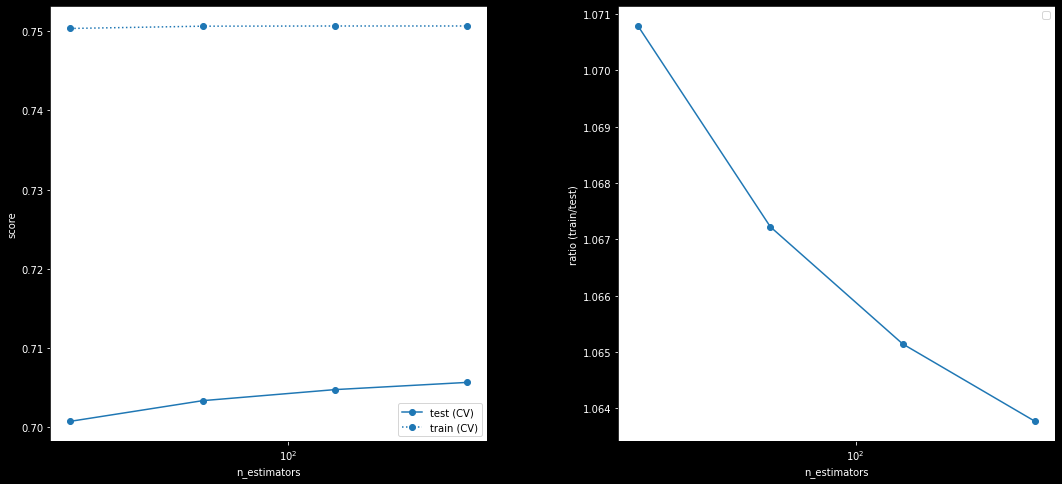

In [55]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['n_estimators'], 
                               name_param='n_estimators',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

tracé de score = f(max_depth) (n_estimators=256)

In [56]:
results_plot = results.copy()
results_plot['all_results'] = \
[elt for elt in results['all_results'] if elt[0]['n_estimators']==256]

(<Figure size 1296x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff83e944a90>,
       dtype=object))

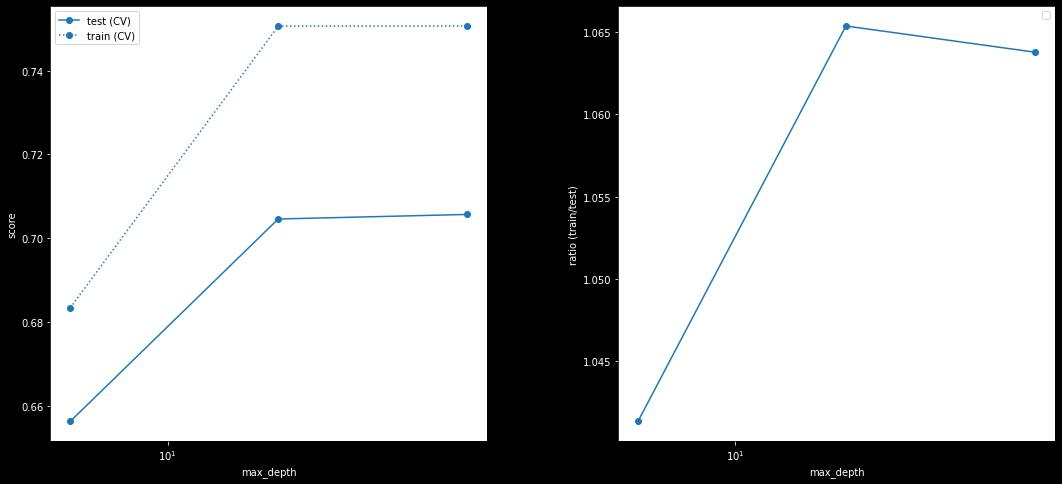

In [57]:
plot_parameter_exploration_reg(results_learner={1:results_plot}, 
                               paramaters=params['max_depth'], 
                               name_param='max_depth',
                               legendleft=['test (CV)','train (CV)'],
                               labelleft='score', labelright='ratio (train/test)',
                               logleft=True, logright=True)

### v) matrices de confusion (échantillon réduit)

sans sample_weight

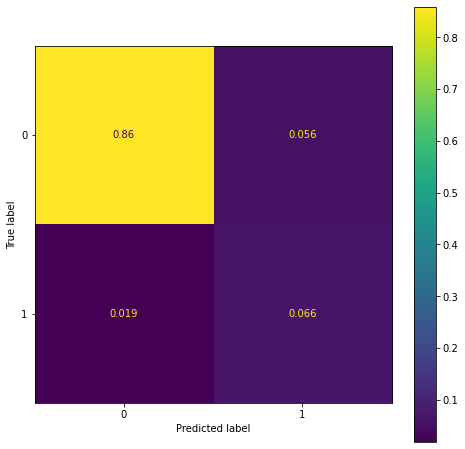

In [ ]:
scorer = make_scorer(my_score)

clf = XGBClassifier()
params_grid = {'n_estimators' : [256],
               'max_depth' : [30],
               'use_label_encoder' : [False],
               'random_state' : [41]}

grid = GridSearchCV(clf, params_grid, scoring=scorer, 
                    return_train_score=True)

grid.fit(X_over_short, y_over_short)

X_test = np.array(X_test)

y_pred = grid.predict(X_test)

labels = np.array([0,1])

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all'),
                             labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)

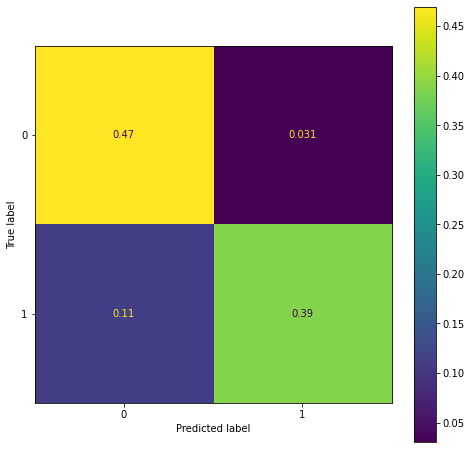

In [ ]:
# matrice de confusion avec sample_weight
labels = np.array([0,1])

weight_0 = (y_test==1).sum() / y_test.size
weight_1 = (y_test==0).sum() / y_test.size
weights = np.where(y_test==0, weight_0,weight_1)

fig = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred,normalize='all',
                                              sample_weight=weights),labels)
figdim, ax = plt.subplots(figsize=(8,8))
fig.plot(ax=ax)